# G0 Marker Analysis

Current working directory: /root/Cycle/Github


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

Figure saved at: ./FigurePlot/neuron_Quiescent/hNSC_U5_Quiescence_Markers_ViolinPlot.png


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

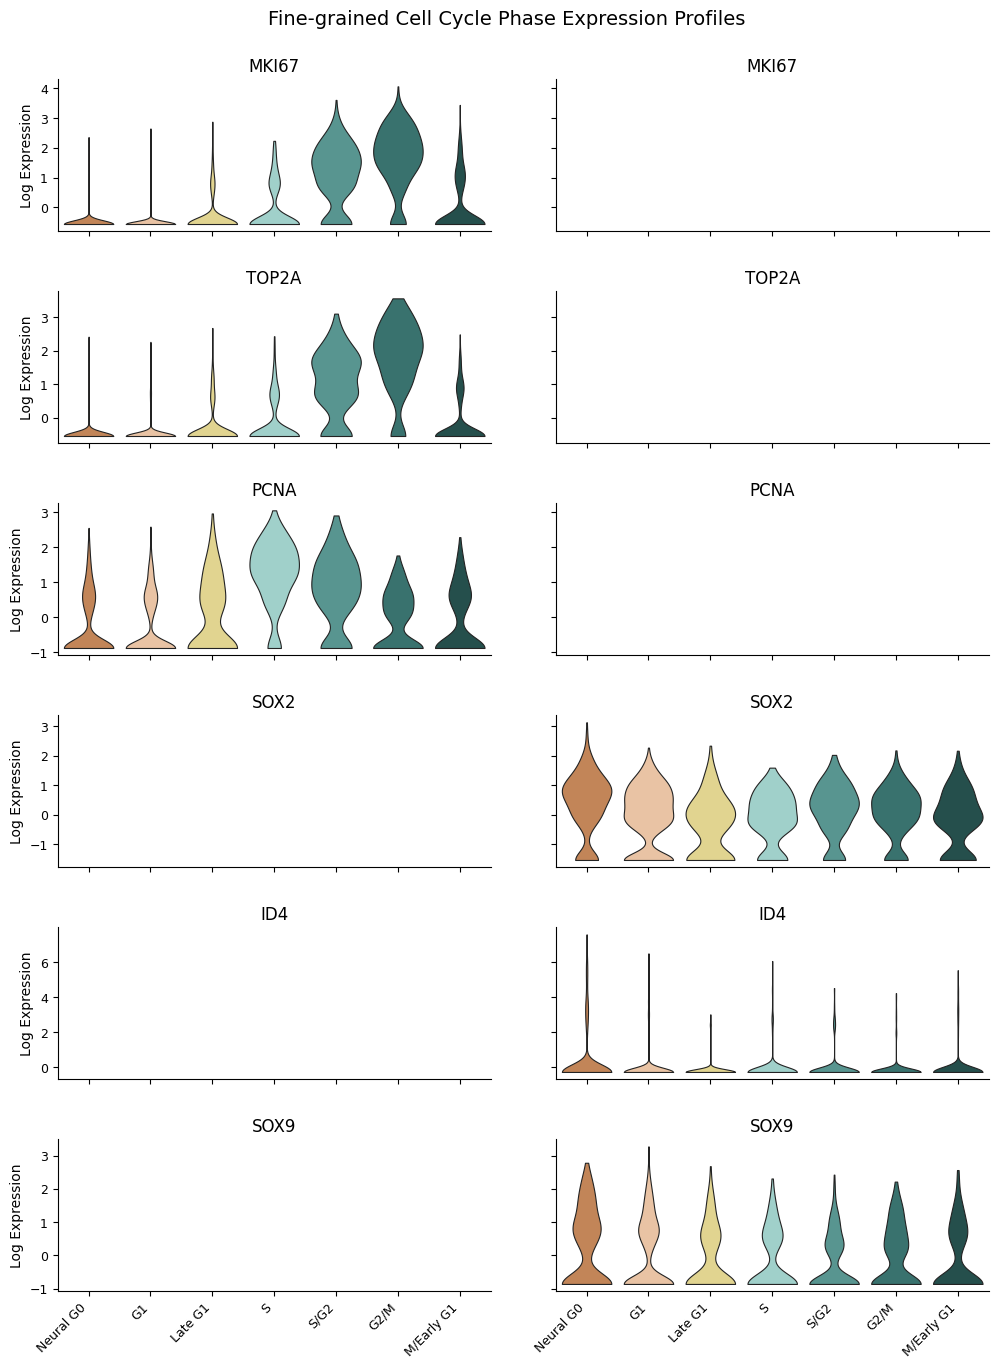

In [1]:
import os
import sys
import scanpy as sc

# ==============================
# Add HarmoCycle module path
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import *

# Load AnnData object
adata_U5 = sc.read_h5ad('./Dataset/hNSC-U5.h5ad')
# Example: adata_U5 = sc.read_h5ad("your_data.h5ad")

# 1. Normalization
# Normalize total counts per cell so that each cell has the same total (default target = 10,000).
sc.pp.normalize_total(adata_U5, target_sum=1e4)

# 2. Logarithmize
# Apply log(X+1) transformation to stabilize variance.
sc.pp.log1p(adata_U5)

# 3. Identify highly variable genes
# Use the 'seurat' method to select the top 2000 highly variable genes for downstream analysis.
sc.pp.highly_variable_genes(adata_U5, n_top_genes=2000, flavor='seurat')

# 4. Scaling
# Scale each gene to mean = 0 and variance = 1.
# max_value=10 clips extreme values.
sc.pp.scale(adata_U5, max_value=10)

# 5. Principal Component Analysis (PCA)
# Perform PCA on highly variable genes.
sc.tl.pca(adata_U5, use_highly_variable=True, svd_solver='arpack')

# 6. Compute neighborhood graph
# Use the first 50 principal components to compute the neighborhood graph.
sc.pp.neighbors(adata_U5, n_pcs=50, n_neighbors=15)

# 7. UMAP dimensionality reduction
# Compute UMAP for 2D visualization.
sc.tl.umap(adata_U5)

# Optional: visualize UMAP
# sc.pl.umap(adata_U5, color=['ClusterName'])

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc

# =========================================================
# 1. Font settings
# =========================================================
# Ensure fonts are preserved in PDF export (Type 42 = TrueType fonts).
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Set default font to Arial (best compatibility with Illustrator).
# If Arial is not available, fallback to 'DejaVu Sans'.
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.family'] = 'sans-serif'

# =========================================================
# 2. Data cleaning and ordering
# =========================================================
# Remove unwanted cluster category
adata_plot = adata_U5[adata_U5.obs['ClusterName'] != 'G1/other'].copy()

# Define cluster order
cluster_order = [
    'Neural G0', 'G1', 'Late G1', 'S', 'S/G2', 'G2/M', 'M/Early G1'
]

# Set categorical order for plotting
adata_plot.obs['ClusterName'] = pd.Categorical(
    adata_plot.obs['ClusterName'], 
    categories=cluster_order, 
    ordered=True
)

# =========================================================
# 3. Plotting code
# =========================================================
adata_plot.var_names_make_unique()

# Define marker genes
cycle_genes = ['MKI67', 'TOP2A', 'PCNA'] 
candidates = ['SOX2', 'ID4', 'SOX9']
quiesc_genes = [g for g in candidates if g in adata_plot.var_names]

plot_genes = cycle_genes + quiesc_genes

# Extract expression data
df_plot = sc.get.obs_df(adata_plot, keys=plot_genes + ['ClusterName'])
df_melt = df_plot.melt(id_vars='ClusterName', var_name='Gene', value_name='Expression')

# Assign gene type
def get_gene_type(g):
    if g in cycle_genes: 
        return 'Cycle Markers'
    else: 
        return 'Quiescence Markers'

df_melt['Type'] = df_melt['Gene'].apply(get_gene_type)

# Define color mapping
color_map = {
    'Neural G0': '#D48346', 'G1': '#F4C299', 'Late G1': '#EEDD82',
    'S': '#98D8D0', 'S/G2': '#4E9F98', 'G2/M': '#2F7C76', 'M/Early G1': '#1E5652'
}

# Create violin plots
g = sns.catplot(
    data=df_melt, x='ClusterName', y='Expression', 
    col='Type', row='Gene', kind='violin',
    hue='ClusterName', palette=color_map, order=cluster_order,
    height=1.5, aspect=3.5, sharey='row', scale='width', 
    cut=0, inner=None, linewidth=0.8
)

# Set titles and labels
g.set_titles("{row_name}", size=12)
g.set_axis_labels("", "Log Expression", size=10)

# Remove legend
if g.legend:
    g.legend.remove()

# Adjust x-axis labels
for ax in g.axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=9)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

plt.subplots_adjust(top=0.93, hspace=0.4, wspace=0.15)
g.fig.suptitle('Fine-grained Cell Cycle Phase Expression Profiles', fontsize=14)

# Set figure size
g.fig.set_size_inches(10, 14)

# =========================================================
# 4. Save figure
# =========================================================
save_path = "./FigurePlot/neuron_Quiescent/hNSC_U5_Quiescence_Markers_ViolinPlot.png"

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure
plt.savefig(save_path, format='png', transparent=True) 

print(f"Figure saved at: {save_path}")
plt.show()


# G0 Cell Dataset Analysis

In [2]:
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.stats import zscore
import os

# ==============================================================================
# 1. Core Settings: Font compatibility & Nature-style color palette
# ==============================================================================

# --- Font and vector settings ---
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
mpl.rcParams['savefig.bbox'] = 'tight'
# Note: Even for vector graphics, dpi affects rendering precision in mixed modes
mpl.rcParams['savefig.dpi'] = 300 

# --- Color palette for cell cycle stages ---
palette_cycle = {
    'G0': '#D48346', 'Quiescent': '#D48346', 'Neural G0': '#D48346', 'Neural.G0': '#D48346',
    'G1': '#F4C299', 'Late G1': '#EEDD82', 'G1/other': '#F4C299',
    'S': '#98D8D0',          
    'S/G2': '#4E9F98', 'G2M': '#2F7C76', 'G2/M': '#2F7C76',
    'M': '#1E5652', 'M/Early G1': '#1E5652',
    'Cycling_LowCount': '#E0E0E0', 'nan': '#E0E0E0', 'Unknown': '#E0E0E0'
}

def get_color_list(labels, mapping):
    """Map labels to colors using predefined palette with fallback rules."""
    colors = []
    for l in labels:
        l_str = str(l)
        if l_str in mapping: 
            colors.append(mapping[l_str])
        elif 'G0' in l_str or 'Quies' in l_str: 
            colors.append(mapping['G0'])
        elif 'G1' in l_str: 
            colors.append(mapping['G1'])
        elif 'G2' in l_str or 'M' in l_str: 
            colors.append(mapping['G2M'])
        elif 'S' in l_str: 
            colors.append(mapping['S'])
        else: 
            colors.append(mapping['nan'])
    return colors

# ==============================================================================
# 2. Data Loading and Processing
# ==============================================================================

def load_comparison_data(hc_path, ccaf_path):
    """Load HarmoCycle and ccAFv2 datasets, align common cells, and merge labels."""
    print(f"Loading {hc_path}...")
    adata = sc.read_h5ad(hc_path)
    adata_ccaf = sc.read_h5ad(ccaf_path)
    common = adata.obs_names.intersection(adata_ccaf.obs_names)
    adata = adata[common].copy()
    adata_ccaf = adata_ccaf[common].copy()
    adata.obs["ccAFv2_labels"] = adata_ccaf.obs["ccAFv2_labels"].astype(str)
    if 'HarmoCycle_Stage' not in adata.obs and 'predicted_cycle_state' in adata.obs:
        adata.obs['HarmoCycle_Stage'] = adata.obs['predicted_cycle_state']
    return adata

def process_pcw8_data_with_umap():
    """Load PCW8 dataset, preprocess, compute PCA/UMAP, and align with HarmoCycle annotations."""
    print("Processing PCW8 Data...")
    path_raw = './Dataset/hNSC-U5.h5ad' 
    hNCS_PCW8 = sc.read_h5ad(path_raw)
    hNCS_PCW8.var_names_make_unique()
    sc.pp.normalize_total(hNCS_PCW8, target_sum=1e4)
    sc.pp.log1p(hNCS_PCW8)
    sc.pp.highly_variable_genes(hNCS_PCW8, n_top_genes=2000, flavor='seurat')
    sc.pp.scale(hNCS_PCW8, max_value=10) 
    sc.tl.pca(hNCS_PCW8, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(hNCS_PCW8, n_pcs=50, n_neighbors=15)
    sc.tl.umap(hNCS_PCW8)
    
    path_harmo = './Experiment/Temp_Result/hNSC-U5/hNSC-U5_annotated.h5ad'
    hNCS_PCW8_Harmo = sc.read_h5ad(path_harmo)
    common_cells = hNCS_PCW8.obs_names.intersection(hNCS_PCW8_Harmo.obs_names)
    hNCS_PCW8 = hNCS_PCW8[common_cells].copy()
    hNCS_PCW8_Harmo = hNCS_PCW8_Harmo[common_cells].copy()
    
    hNCS_PCW8.obs['HarmoCycle_Stage'] = hNCS_PCW8_Harmo.obs['HarmoCycle_Stage'].values
    if 'corrected_density' in hNCS_PCW8_Harmo.obs:
        hNCS_PCW8.obs['corrected_density'] = zscore(hNCS_PCW8_Harmo.obs['corrected_density'].values)
    if 'X_pca_adjust' in hNCS_PCW8_Harmo.obsm:
        hNCS_PCW8.obsm['X_pca_adjust'] = hNCS_PCW8_Harmo.obsm['X_pca_adjust']
    return hNCS_PCW8

# ==============================================================================
# 3. Integrated Plotting Function (with unified save logic)
# ==============================================================================

def plot_figure_integrated(dataset_configs, save_dir="./FigurePlot/neuron_Quiescent", save_name="multi_dataset_G0.pdf"):
    """Plot integrated comparison figures across datasets and save as vector PDF."""
    n_rows = len(dataset_configs)
    n_cols = 4 
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
    plt.subplots_adjust(wspace=0.15, hspace=0.3, bottom=0.1)
    
    if n_rows == 1: 
        axs = axs.reshape(1, -1)
    
    for row_idx, config in enumerate(dataset_configs):
        adata = config['adata']
        title = config['name']
        
        umap = adata.obsm['X_umap']
        pca_adj = adata.obsm['X_pca_adjust'] if 'X_pca_adjust' in adata.obsm else adata.obsm['X_pca']
        
        indices = np.arange(len(adata))
        np.random.shuffle(indices) 
        pt_size = 8 if len(adata) > 10000 else 20
        
        # Common scatter plot parameters (force vector output: rasterized=False)
        scatter_kwargs = {
            's': pt_size,
            'alpha': 0.9,
            'edgecolors': 'none',
            'linewidth': 0,
            'rasterized': False
        }
        
        # -------------------------------------------------------
        # Column 1: Reference
        # -------------------------------------------------------
        ax1 = axs[row_idx, 0]
        col1_key = config['col1_key']
        col1_type = config.get('col1_type', 'discrete')
        
        if col1_type == 'discrete':
            labels = adata.obs[col1_key]
            uniques = [u for u in labels.unique() if str(u) != 'nan']
            cmap = plt.cm.get_cmap('tab20', len(uniques)) 
            c_dict = {u: cmap(i) for i, u in enumerate(uniques)}
            colors = [c_dict.get(l, (0.9,0.9,0.9)) for l in labels]
            ax1.scatter(umap[indices, 0], umap[indices, 1], c=np.array(colors)[indices], **scatter_kwargs)
            ax1.set_title(f"Ref: {col1_key}", fontsize=11, fontweight='bold')
        else:
            vals = adata.obs[col1_key].values
            sc1 = ax1.scatter(umap[indices, 0], umap[indices, 1], c=vals[indices], cmap='viridis', **scatter_kwargs)
            cbar = plt.colorbar(sc1, ax=ax1, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=8)
            ax1.set_title(col1_key, fontsize=11, fontweight='bold')

        ax1.set_ylabel(title, fontsize=12, fontweight='bold')
        ax1.set_xticks([]); ax1.set_yticks([])
        for spine in ax1.spines.values(): spine.set_visible(False)

        # -------------------------------------------------------
        # Column 2: HarmoCycle
        # -------------------------------------------------------
        ax2 = axs[row_idx, 1]
        labels_hc = adata.obs['HarmoCycle_Stage'].values
        colors_hc = get_color_list(labels_hc, palette_cycle)
        ax2.scatter(umap[indices, 0], umap[indices, 1], c=np.array(colors_hc)[indices], **scatter_kwargs)
        ax2.set_title("HarmoCycle", fontsize=11, fontweight='bold')
        ax2.set_xticks([]); ax2.set_yticks([])
        for spine in ax2.spines.values(): spine.set_visible(False)

        # -------------------------------------------------------
        # Column 3: Comparison
        # -------------------------------------------------------
        ax3 = axs[row_idx, 2]
        col3_key = config['col3_key']
        col3_type = config.get('col3_type', 'discrete')
        
        if col3_type == 'discrete':
            labels_cc = adata.obs[col3_key].values
            colors_cc = get_color_list(labels_cc, palette_cycle)
            ax3.scatter(umap[indices, 0], umap[indices, 1], c=np.array(colors_cc)[indices], **scatter_kwargs)
            ax3.set_title(f"Comp: {col3_key}", fontsize=11, fontweight='bold')
        else:
            vals = adata.obs[col3_key].values
            sc3 = ax3.scatter(umap[indices, 0], umap[indices, 1], c=vals[indices], cmap='magma', **scatter_kwargs)
            cbar = plt.colorbar(sc3, ax=ax3, fraction=0.046, pad=0.04)
            cbar.set_label("Score / Density", fontsize=8)
            cbar.ax.tick_params(labelsize=8)
            ax3.set_title(col3_key, fontsize=11, fontweight='bold')
            
        ax3.set_xticks([]); ax3.set_yticks([])
        for spine in ax3.spines.values(): spine.set_visible(False)

        # -------------------------------------------------------
        # Column 4: Topology
        # -------------------------------------------------------
        ax4 = axs[row_idx, 3]
        col4_key = config.get('col4_key', 'topology')
        
        if col4_key == 'topology':
            ax4.scatter(pca_adj[indices, 0], pca_adj[indices, 1], c=np.array(colors_hc)[indices], **scatter_kwargs)
            ax4.set_title("Spectral Topology", fontsize=11, fontweight='bold')
        elif col4_key == 'ccAFv2_labels':
            labels_cc = adata.obs['ccAFv2_labels'].values
            colors_cc = get_color_list(labels_cc, palette_cycle)
            ax4.scatter(umap[indices, 0], umap[indices, 1], c=np.array(colors_cc)[indices], **scatter_kwargs)
            ax4.set_title("ccAFv2", fontsize=11, fontweight='bold')
            
        ax4.set_xticks([]); ax4.set_yticks([])
        for spine in ax4.spines.values(): spine.set_visible(False)

    # -------------------------------------------------------
    # Unified save logic
    # -------------------------------------------------------
    os.makedirs(save_dir, exist_ok=True)
    out_file = os.path.join(save_dir, save_name)
    plt.savefig(out_file, format="pdf", bbox_inches="tight", dpi=300, transparent=True)
    print(f"Vector PDF saved to: {out_file}")
    plt.show()


# Poised Cluster Analysis

In [3]:
adata0 = sc.read_h5ad('./Dataset/hNSC-U5.h5ad')
adata1 = sc.read_h5ad('./Experiment/Temp_Result/hNSC-U5/hNSC-U5_annotated.h5ad')

import numpy as np

# Initialize a new column for validation grouping
adata1.obs['Validation_Group'] = np.nan

# 1. Consensus G0: cells in adata0 where ClusterName == 'Neural G0'
consensus_g0_cells = adata0.obs.index[adata0.obs['ClusterName'] == 'Neural G0']
adata1.obs.loc[consensus_g0_cells, 'Validation_Group'] = 'Consensus G0'

# 2. Poised G0: cells with HarmoCycle_Stage == 'G0' but not part of Neural G0
poised_g0_cells = adata1.obs.index[
    (adata1.obs['HarmoCycle_Stage'] == 'G0') & 
    (~adata1.obs.index.isin(consensus_g0_cells))
]
adata1.obs.loc[poised_g0_cells, 'Validation_Group'] = 'Poised G0'

# 3. Consensus Cycling: cells with HarmoCycle_Stage != 'G0'
cycling_cells = adata1.obs.index[adata1.obs['HarmoCycle_Stage'] != 'G0']
adata1.obs.loc[cycling_cells, 'Validation_Group'] = 'Consensus Cycling'

# Keep only the three defined categories of cells
adata1 = adata1[adata1.obs['Validation_Group'].notna()].copy()

# Check the result distribution
print(adata1.obs['Validation_Group'].value_counts())

adata = adata1.copy()

Consensus Cycling    1414
Poised G0            1127
Consensus G0          474
Name: Validation_Group, dtype: int64


/tmp/ipykernel_80503/1228160384.py:86: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


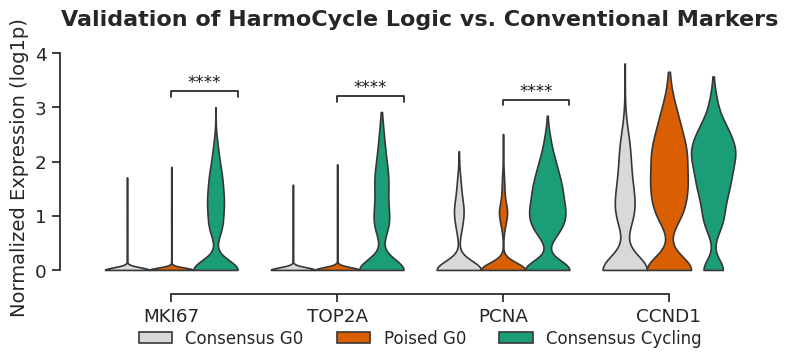

In [4]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

# Normalize and log-transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)  

# ================= Configuration Section =================
# Define the list of genes to plot
genes_to_plot = ['MKI67', 'TOP2A', 'PCNA', 'CCND1']

# Define the order of groups for plotting
hue_order = ['Consensus G0', 'Poised G0', 'Consensus Cycling']

# Define color palette (matching your figure style)
palette = {
    'Consensus G0': '#d9d9d9',       # Gray (background)
    'Poised G0': '#d95f02',          # Orange (highlight of HarmoCycle)
    'Consensus Cycling': '#1b9e77'   # Green (control group)
}

# Prepare data (assuming adata already has 'Validation_Group' column from previous step)
# Simplify group names for consistency
adata.obs['Validation_Group'] = adata.obs['Validation_Group'].replace({
    'Poised G0\n(HarmoCycle Only)': 'Poised G0'
})

# Extract expression data for selected genes and group labels
df_plot = sc.get.obs_df(adata, keys=genes_to_plot + ['Validation_Group'])
df_melt = df_plot.melt(id_vars='Validation_Group', var_name='Gene', value_name='Expression')

# Filter out groups not in hue_order (if any exist)
df_melt = df_melt[df_melt['Validation_Group'].isin(hue_order)]

# ================= Function for Statistical Annotation =================
def add_stat_annotation(ax, data, gene, group1, group2, hue_order, x_pos, y_max_scale=1.05):
    """
    Manually add statistical significance annotation between two groups for a given gene.
    """
    # 1. Extract data for the two groups
    g1_data = data[(data['Gene'] == gene) & (data['Validation_Group'] == group1)]['Expression']
    g2_data = data[(data['Gene'] == gene) & (data['Validation_Group'] == group2)]['Expression']
    
    # 2. Perform Mann-Whitney U test
    stat, p = mannwhitneyu(g1_data, g2_data, alternative='two-sided')
    
    # 3. Convert p-value to significance stars
    if p >= 0.05: text = 'ns'
    elif p < 0.0001: text = '****'
    elif p < 0.001: text = '***'
    elif p < 0.01: text = '**'
    else: text = '*'
    
    # 4. Determine x-axis positions
    # Seaborn violinplot x-axis is integers (0, 1, 2...) corresponding to gene order
    # Hue offset is typically around -0.26, 0, +0.26 depending on width
    x_center = x_pos
    width = 1.2
    n_hues = len(hue_order)
    idx1 = hue_order.index(group1)
    idx2 = hue_order.index(group2)
    
    # Calculate relative offsets
    offset_step = width / n_hues
    start_offset = -width/2 + offset_step/2
    x1 = x_center + start_offset + (idx1 * offset_step)
    x2 = x_center + start_offset + (idx2 * offset_step)
    
    # Determine y-axis height (slightly above max expression of both groups)
    y_max = max(g1_data.max(), g2_data.max())
    y_h = y_max + (data['Expression'].max() * 0.05)
    
    # 5. Draw annotation line and text
    ax.plot([x1, x1, x2, x2], [y_h, y_h+0.1, y_h+0.1, y_h], lw=1.2, c='k')
    ax.text((x1+x2)/2, y_h+0.1, text, ha='center', va='bottom', color='k', fontsize=12)

# ================= Plotting =================
plt.figure(figsize=(8, 4))
sns.set_theme(style="ticks", font_scale=1.2)

# Main violin plot
ax = sns.violinplot(
    data=df_melt, 
    x='Gene', 
    y='Expression', 
    hue='Validation_Group',
    hue_order=hue_order,
    palette=palette,
    scale='width',
    linewidth=1.2,
    cut=0,
    inner=None,   # Remove internal lines for cleaner look
    saturation=1
)

# Optional: overlay boxplot for additional information (commented out if too cluttered)
# sns.boxplot(data=df_melt, x='Gene', y='Expression', hue='Validation_Group', hue_order=hue_order,
#             palette=palette, dodge=True, width=0.2, boxprops={'zorder': 2, 'alpha': 0.5},
#             ax=ax, showfliers=False)

# Add statistical annotations (focus on MKI67, TOP2A, PCNA)
for i, gene in enumerate(genes_to_plot):
    if gene in ['MKI67', 'TOP2A', 'PCNA']:  # CCND1 can be excluded or analyzed separately
        add_stat_annotation(ax, df_melt, gene, 'Poised G0', 'Consensus Cycling', hue_order, i)

# Beautify plot
sns.despine(trim=True, offset=10)
plt.xlabel('')
plt.ylabel('Normalized Expression (log1p)', fontsize=14)
plt.title('Validation of HarmoCycle Logic vs. Conventional Markers', fontsize=16, fontweight='bold', pad=20)

# Optimize legend placement
plt.legend(title='', frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=12)

plt.tight_layout()

# Define target folder and file path
out_dir = "./FigurePlot/neuron_Quiescent"
out_file = os.path.join(out_dir, "Poised_Cluster_Marker.pdf")

# Create folder if it does not exist
os.makedirs(out_dir, exist_ok=True)

# Save figure as PDF
plt.savefig(out_file, format="pdf", bbox_inches="tight", dpi=300)

# Show plot
plt.show()


# Marker Gene ID2 validation attractor

Figure saved at: ./FigurePlot/neuron_Quiescent/hNSC_U5_QuiescentCluster_ID2.png


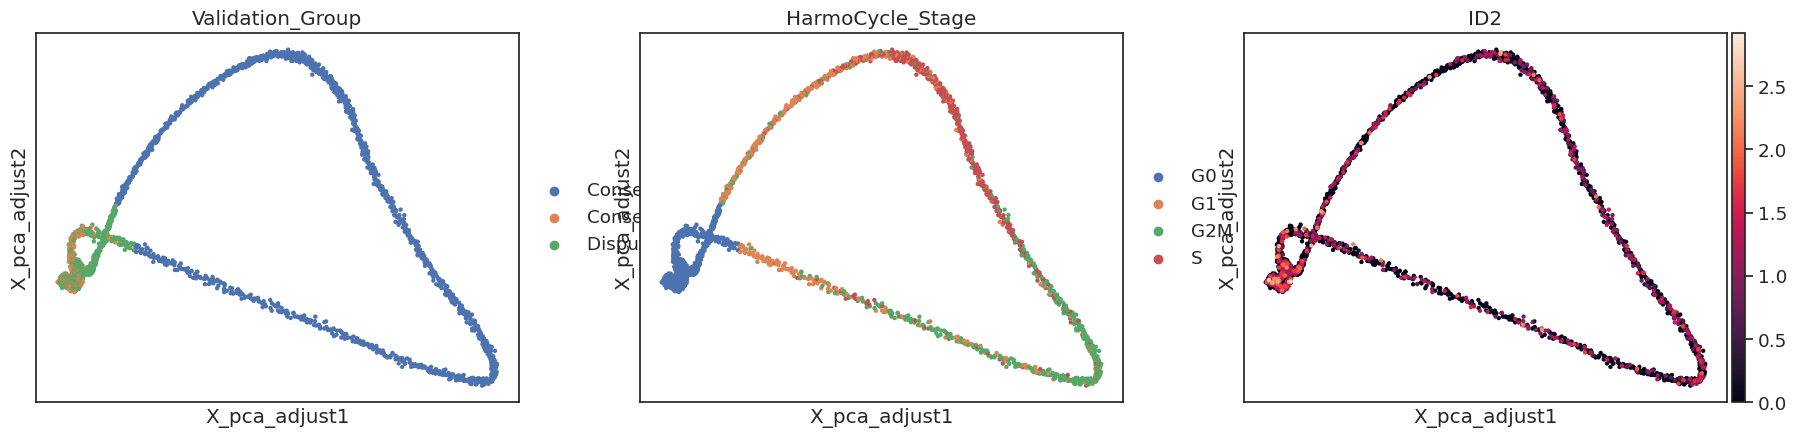

In [5]:
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt

# Load datasets
adata0 = sc.read_h5ad('./Dataset/hNSC-U5.h5ad')
adata1 = sc.read_h5ad('./Experiment/Temp_Result/hNSC-U5/hNSC-U5_annotated.h5ad')

# Initialize a new column for validation grouping
adata1.obs['Validation_Group'] = np.nan

# 1. Consensus G0: cells in adata0 where ClusterName == 'Neural G0'
consensus_g0_cells = adata0.obs.index[adata0.obs['ClusterName'] == 'Neural G0']
adata1.obs.loc[consensus_g0_cells, 'Validation_Group'] = 'Consensus G0'

# 2. Disputed G0: cells with HarmoCycle_Stage == 'G0' but not part of Neural G0
poised_g0_cells = adata1.obs.index[
    (adata1.obs['HarmoCycle_Stage'] == 'G0') & 
    (~adata1.obs.index.isin(consensus_g0_cells))
]
adata1.obs.loc[poised_g0_cells, 'Validation_Group'] = 'Disputed G0'

# 3. Consensus Cycling: cells with HarmoCycle_Stage != 'G0'
cycling_cells = adata1.obs.index[adata1.obs['HarmoCycle_Stage'] != 'G0']
adata1.obs.loc[cycling_cells, 'Validation_Group'] = 'Consensus Cycling'

# Keep only the three defined categories of cells
adata1 = adata1[adata1.obs['Validation_Group'].notna()].copy()

# Normalize and log-transform
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)

# Plot PCA-adjusted embedding colored by Validation_Group, HarmoCycle_Stage, and ID2
ax = sc.pl.embedding(
    adata1, 
    basis='X_pca_adjust', 
    color=['Validation_Group', 'HarmoCycle_Stage', 'ID2'],
    show=False   # <-- important: do not show immediately
)

# Define save path
save_path = "./FigurePlot/neuron_Quiescent/hNSC_U5_QuiescentCluster_ID2.png"

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure as PNG with transparent background
plt.savefig(save_path, format='png', transparent=True, dpi=300)

print(f"Figure saved at: {save_path}")

# Show figure (optional, useful in interactive environments)
plt.show()



# Gini index (mESC)

Current working directory: /root/Cycle/Github
Epoch 1/2000, Loss: 1.1292
Epoch 50/2000, Loss: 0.9751
Epoch 100/2000, Loss: 0.9264
Epoch 150/2000, Loss: 0.8794
Epoch 200/2000, Loss: 0.8375
Epoch 250/2000, Loss: 0.8020
Epoch 300/2000, Loss: 0.7671
Epoch 350/2000, Loss: 0.7408
Epoch 400/2000, Loss: 0.7152
Epoch 450/2000, Loss: 0.6928
Epoch 500/2000, Loss: 0.6748
Epoch 550/2000, Loss: 0.6572
Epoch 600/2000, Loss: 0.6427
Epoch 650/2000, Loss: 0.6296
Epoch 700/2000, Loss: 0.6153
Epoch 750/2000, Loss: 0.6034
Epoch 800/2000, Loss: 0.5933
Epoch 850/2000, Loss: 0.5808
Epoch 900/2000, Loss: 0.5713
Epoch 950/2000, Loss: 0.5608
Epoch 1000/2000, Loss: 0.5527
Epoch 1050/2000, Loss: 0.5439
Epoch 1100/2000, Loss: 0.5380
Epoch 1150/2000, Loss: 0.5303
Epoch 1200/2000, Loss: 0.5255
Epoch 1250/2000, Loss: 0.5157
Epoch 1300/2000, Loss: 0.5138
Epoch 1350/2000, Loss: 0.5079
Epoch 1400/2000, Loss: 0.5021
Epoch 1450/2000, Loss: 0.4953
Epoch 1500/2000, Loss: 0.4887
Epoch 1550/2000, Loss: 0.4841
Epoch 1600/2000, 

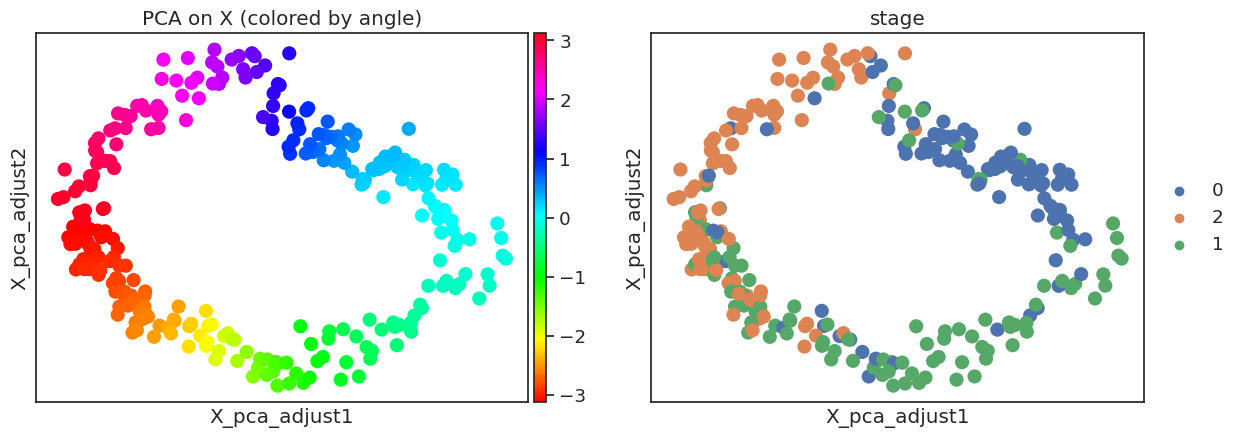

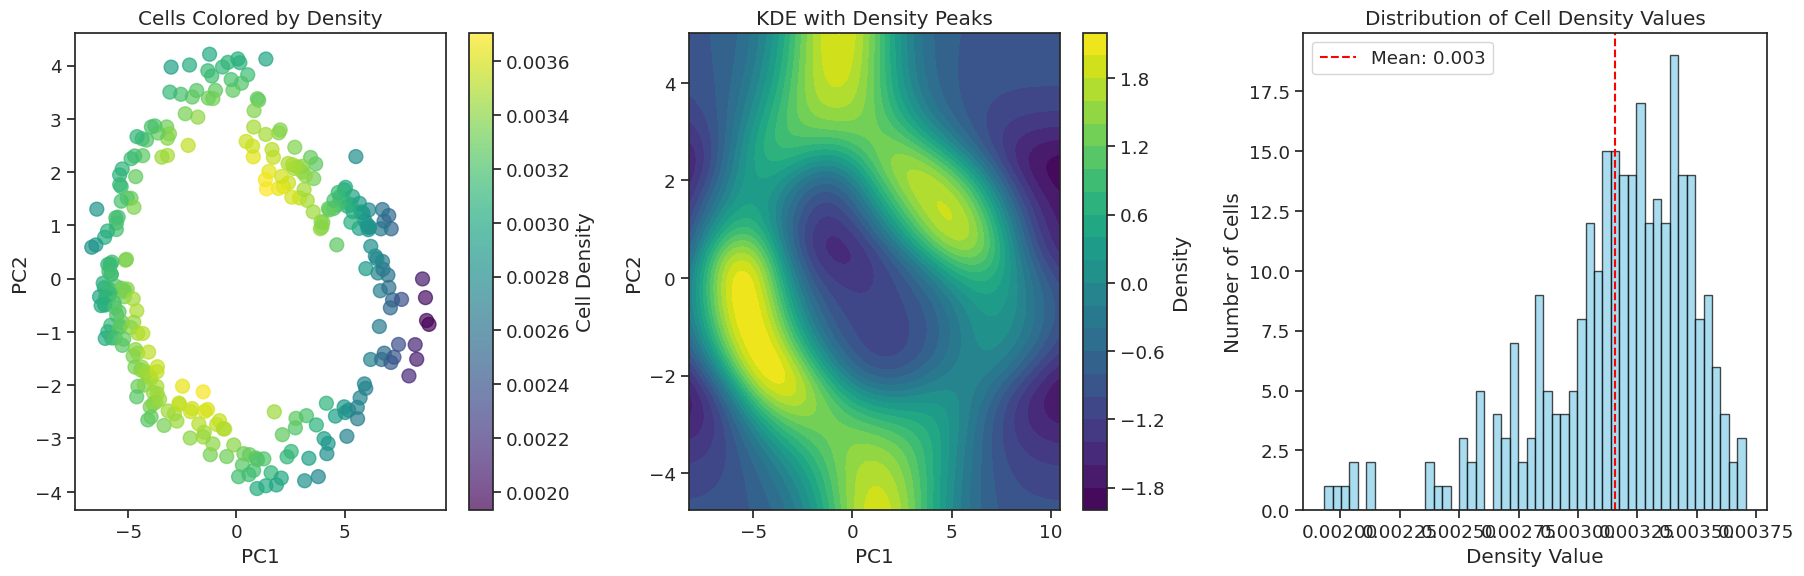

Computed density values for 288 cells
Density range: 0.0019 - 0.0037
Mean density: 0.0032
Standard deviation: 0.0003

Found 0 density peaks
Top 5 density peaks (x, y, density):
Figure saved at: ./FigurePlot/neuron_Quiescent/mESC_attractor_reference.png


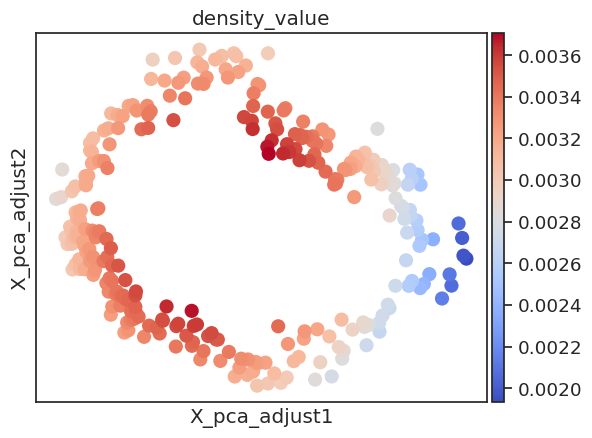

0.056


In [6]:
import os
import sys
import scanpy as sc

# ==============================
# Add HarmoCycle module path
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import *
set_seed(79710)

import os
import pandas as pd
import scanpy as sc
import numpy as np
from functools import reduce
from scipy import stats

adata_query = sc.read_h5ad('./Dataset/mESC.h5ad')

refer_adata3 = sc.read_h5ad('./Experiment/Temp_Result/mESCQ_adjusted_adata.h5ad')
refer_adata2 = sc.read_h5ad('./Experiment/Temp_Result/hU2OS_adjusted_adata.h5ad')
refer_adata4 = sc.read_h5ad('./Experiment/Temp_Result/hESC_adjusted_adata.h5ad')

def gini(x):
    x = np.asarray(x, dtype=float).flatten()
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    cum = np.cumsum(x_sorted)
    g = (2.0 * np.sum((np.arange(1, n+1) * x_sorted))) / (n * cum[-1]) - (n + 1) / n
    return g

gene_set2 = get_adjust_gene(refer_adata=refer_adata2, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set3 = get_adjust_gene(refer_adata=refer_adata3, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set4 = get_adjust_gene(refer_adata=refer_adata4, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_union = reduce(np.union1d, [gene_set2, gene_set3, gene_set4])

adata_res1 = run_test(gene_set=gene_union, adata_source=adata_query.copy(), is_norm=True, is_scale=True)
adata1 = adata_query[adata_res1.obs.index, ]
adata1.obsm['X_pca_adjust'] = adata_res1.obsm['X_pca_adjust']
adata1.obs = adata_res1.obs
data = adata1.obsm['X_pca_adjust']

cell_density_values, density_peaks, density_2d, xx, yy = main(data, bandwidth=5)

adata1.obs['density_value'] = cell_density_values
adata1.uns['density_2d'] = density_2d
adata1.uns['density_grid_xx'] = xx
adata1.uns['density_grid_yy'] = yy
adata1.uns['density_peaks'] = density_peaks

# Recreate AnnData object to ensure clean structure
adata1 = sc.AnnData(
    X=adata1.X,
    obs=adata1.obs.copy(),
    var=adata1.var.copy(),
    obsm=adata1.obsm.copy(),
    uns=adata1.uns.copy()
)

# Add density values to observation metadata
adata1.obs['density_value'] = cell_density_values

# Plot PCA-adjusted embedding with red–blue colormap
ax = sc.pl.embedding(
    adata1,
    basis='X_pca_adjust',
    color=['density_value'],
    cmap='coolwarm',   # red–blue gradient
    show=False         # <--- important: do not show immediately
)

# Define save path
save_path = "./FigurePlot/neuron_Quiescent/mESC_attractor_reference.png"

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure as PNG with transparent background
plt.savefig(save_path, format='png', transparent=True, dpi=300)

print(f"Figure saved at: {save_path}")

# Show figure (optional)
plt.show()


# Calculate and print Gini coefficient of density values
gini_value = np.round(gini(cell_density_values), 3)
print(gini_value)


# Gini index (hESC)

Current working directory: /root/Cycle/Github


Epoch 1/2000, Loss: 1.1471
Epoch 50/2000, Loss: 0.9993
Epoch 100/2000, Loss: 0.9354
Epoch 150/2000, Loss: 0.8818
Epoch 200/2000, Loss: 0.8321
Epoch 250/2000, Loss: 0.7901
Epoch 300/2000, Loss: 0.7516
Epoch 350/2000, Loss: 0.7236
Epoch 400/2000, Loss: 0.6962
Epoch 450/2000, Loss: 0.6739
Epoch 500/2000, Loss: 0.6525
Epoch 550/2000, Loss: 0.6324
Epoch 600/2000, Loss: 0.6159
Epoch 650/2000, Loss: 0.6010
Epoch 700/2000, Loss: 0.5834
Epoch 750/2000, Loss: 0.5693
Epoch 800/2000, Loss: 0.5556
Epoch 850/2000, Loss: 0.5440
Epoch 900/2000, Loss: 0.5357
Epoch 950/2000, Loss: 0.5199
Epoch 1000/2000, Loss: 0.5151
Epoch 1050/2000, Loss: 0.5043
Epoch 1100/2000, Loss: 0.4941
Epoch 1150/2000, Loss: 0.4859
Epoch 1200/2000, Loss: 0.4768
Epoch 1250/2000, Loss: 0.4718
Epoch 1300/2000, Loss: 0.4661
Epoch 1350/2000, Loss: 0.4568
Epoch 1400/2000, Loss: 0.4524
Epoch 1450/2000, Loss: 0.4433
Epoch 1500/2000, Loss: 0.4351
Epoch 1550/2000, Loss: 0.4300
Epoch 1600/2000, Loss: 0.4238
Epoch 1650/2000, Loss: 0.4197
Epo

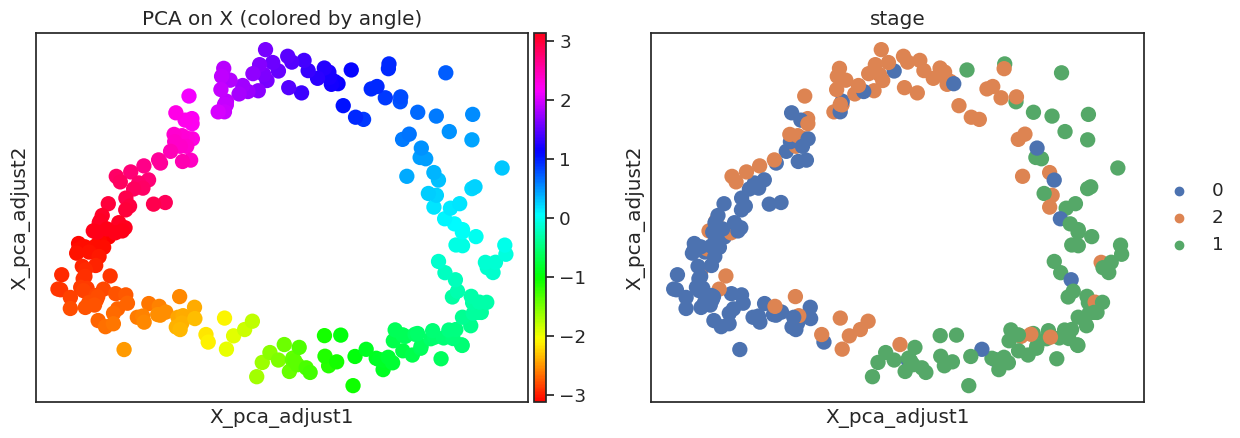

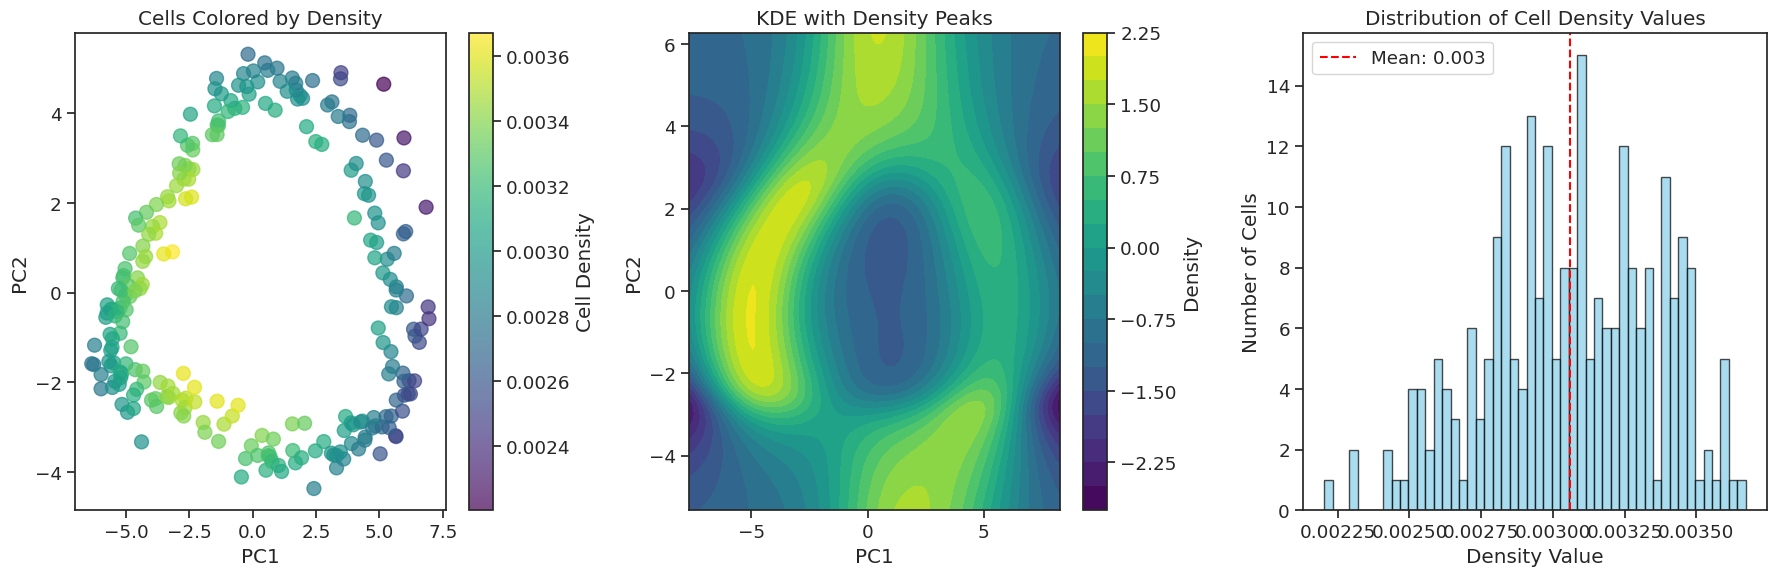

Computed density values for 247 cells
Density range: 0.0022 - 0.0037
Mean density: 0.0031
Standard deviation: 0.0003

Found 0 density peaks
Top 5 density peaks (x, y, density):
Figure saved at: ./FigurePlot/neuron_Quiescent/hESC_attractor_reference.png


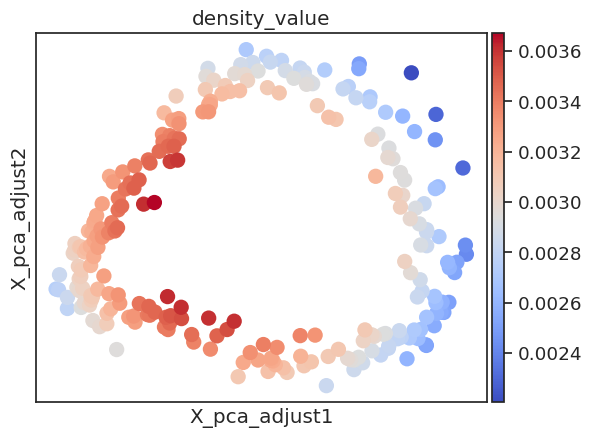

0.056


In [7]:
import os
import sys
import scanpy as sc

# ==============================
# Add HarmoCycle module path
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import *
set_seed(79710)

import os
import pandas as pd
import scanpy as sc
import numpy as np
from functools import reduce
from scipy import stats

adata_query = sc.read_h5ad('./Dataset/hESC.h5ad')

refer_adata3 = sc.read_h5ad('./Experiment/Temp_Result/mESCQ_adjusted_adata.h5ad')
refer_adata2 = sc.read_h5ad('./Experiment/Temp_Result/hU2OS_adjusted_adata.h5ad')
refer_adata4 = sc.read_h5ad('./Experiment/Temp_Result/mESC_adjusted_adata.h5ad')

def gini(x):
    x = np.asarray(x, dtype=float).flatten()
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    cum = np.cumsum(x_sorted)
    g = (2.0 * np.sum((np.arange(1, n+1) * x_sorted))) / (n * cum[-1]) - (n + 1) / n
    return g

gene_set2 = get_adjust_gene(refer_adata=refer_adata2, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set3 = get_adjust_gene(refer_adata=refer_adata3, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set4 = get_adjust_gene(refer_adata=refer_adata4, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_union = reduce(np.union1d, [gene_set2, gene_set3, gene_set4])

adata_res1 = run_test(gene_set=gene_union, adata_source=adata_query.copy(), is_norm=True, is_scale=True)
adata1 = adata_query[adata_res1.obs.index, ]
adata1.obsm['X_pca_adjust'] = adata_res1.obsm['X_pca_adjust']
adata1.obs = adata_res1.obs
data = adata1.obsm['X_pca_adjust']

cell_density_values, density_peaks, density_2d, xx, yy = main(data, bandwidth=5)

adata1.obs['density_value'] = cell_density_values
adata1.uns['density_2d'] = density_2d
adata1.uns['density_grid_xx'] = xx
adata1.uns['density_grid_yy'] = yy
adata1.uns['density_peaks'] = density_peaks

# Recreate AnnData object to ensure clean structure
adata1 = sc.AnnData(
    X=adata1.X,
    obs=adata1.obs.copy(),
    var=adata1.var.copy(),
    obsm=adata1.obsm.copy(),
    uns=adata1.uns.copy()
)

# Add density values to observation metadata
adata1.obs['density_value'] = cell_density_values

# Plot PCA-adjusted embedding with red–blue colormap
sc.pl.embedding(
    adata1,
    basis='X_pca_adjust',
    color=['density_value'],
    cmap='coolwarm',   # red–blue gradient
    show=False  
)

# Define save path
save_path = "./FigurePlot/neuron_Quiescent/hESC_attractor_reference.png"

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure as PNG with transparent background
plt.savefig(save_path, format='png', transparent=True)

print(f"Figure saved at: {save_path}")

# Show figure (optional, useful in interactive environments)
plt.show()

# Calculate and print Gini coefficient of density values
gini_value = np.round(gini(cell_density_values), 3)
print(gini_value)


# Gini index (hNSC-U5-with-four-reference)

Current working directory: /root/Cycle/Github


Epoch 1/2000, Loss: 1.1070
Epoch 50/2000, Loss: 1.0154
Epoch 100/2000, Loss: 1.0063
Epoch 150/2000, Loss: 0.9987
Epoch 200/2000, Loss: 0.9921
Epoch 250/2000, Loss: 0.9874
Epoch 300/2000, Loss: 0.9815
Epoch 350/2000, Loss: 0.9771
Epoch 400/2000, Loss: 0.9720
Epoch 450/2000, Loss: 0.9698
Epoch 500/2000, Loss: 0.9692
Epoch 550/2000, Loss: 0.9655
Epoch 600/2000, Loss: 0.9610
Epoch 650/2000, Loss: 0.9593
Epoch 700/2000, Loss: 0.9555
Epoch 750/2000, Loss: 0.9536
Epoch 800/2000, Loss: 0.9542
Epoch 850/2000, Loss: 0.9515
Epoch 900/2000, Loss: 0.9503
Epoch 950/2000, Loss: 0.9467
Epoch 1000/2000, Loss: 0.9445
Epoch 1050/2000, Loss: 0.9468
Epoch 1100/2000, Loss: 0.9426
Epoch 1150/2000, Loss: 0.9389
Epoch 1200/2000, Loss: 0.9413
Epoch 1250/2000, Loss: 0.9420
Epoch 1300/2000, Loss: 0.9391
Epoch 1350/2000, Loss: 0.9339
Epoch 1400/2000, Loss: 0.9328
Epoch 1450/2000, Loss: 0.9324
Epoch 1500/2000, Loss: 0.9312
Epoch 1550/2000, Loss: 0.9282
Epoch 1600/2000, Loss: 0.9281
Epoch 1650/2000, Loss: 0.9295
Epo

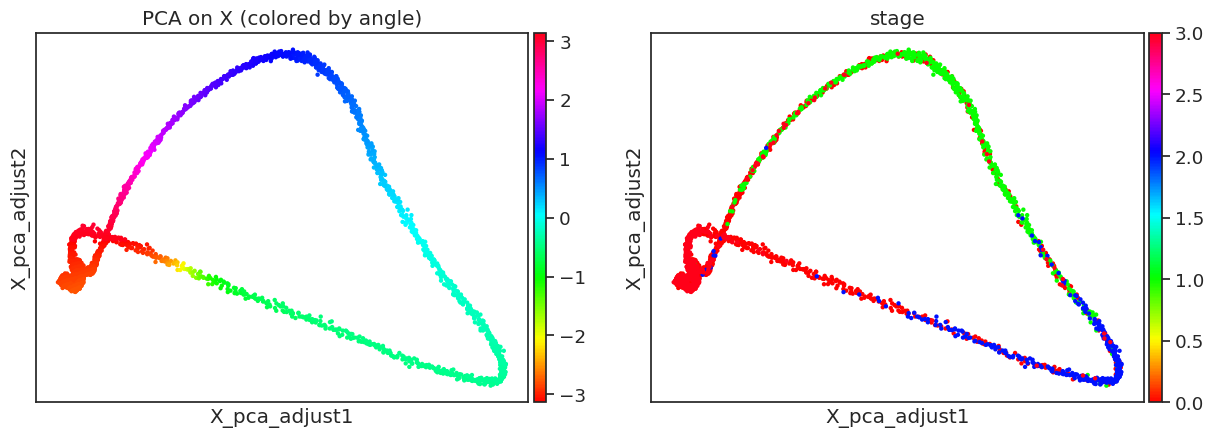

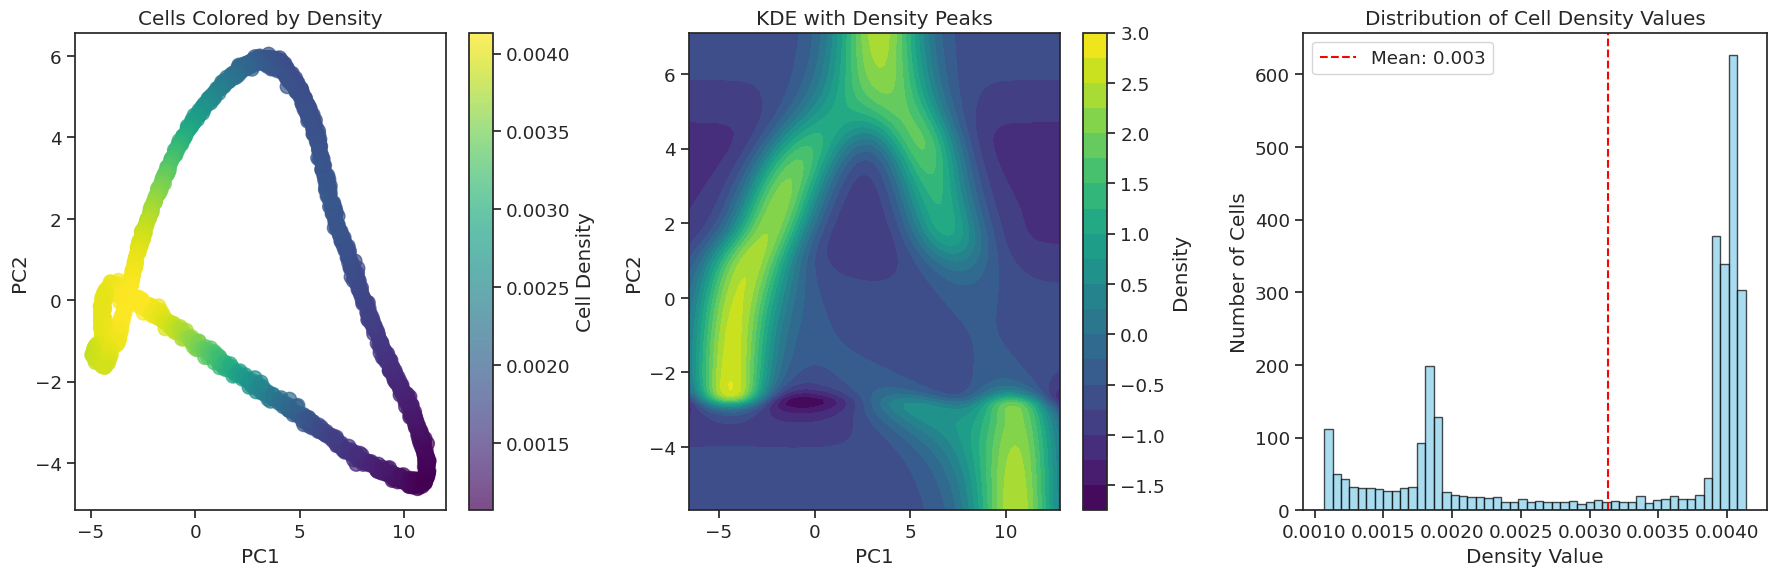

Computed density values for 3015 cells
Density range: 0.0011 - 0.0041
Mean density: 0.0031
Standard deviation: 0.0011

Found 0 density peaks
Top 5 density peaks (x, y, density):
Figure saved at: ./FigurePlot/neuron_Quiescent/hNSC-U5_attractor_with_four_reference.png


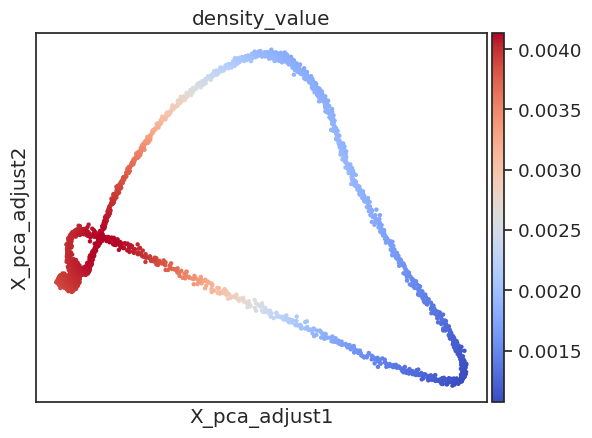

0.185


In [8]:
import os
import sys
import scanpy as sc

# ==============================
# Add HarmoCycle module path
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import *
set_seed(79710)

import os
import pandas as pd
import scanpy as sc
import numpy as np
from functools import reduce
from scipy import stats

adata2 = sc.read_h5ad('./Dataset/hNSC-U5.h5ad')
adata2.var_names_make_unique()
adata_query = adata2

refer_adata1 = sc.read_h5ad('./Experiment/Temp_Result/mESCQ_adjusted_adata.h5ad')
refer_adata3 = sc.read_h5ad('./Experiment/Temp_Result/hU2OS_adjusted_adata.h5ad')
refer_adata2 = sc.read_h5ad('./Experiment/Temp_Result/hESC_adjusted_adata.h5ad')
refer_adata4 = sc.read_h5ad('./Experiment/Temp_Result/mESC_adjusted_adata.h5ad')

def gini(x):
    x = np.asarray(x, dtype=float).flatten()
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    cum = np.cumsum(x_sorted)
    g = (2.0 * np.sum((np.arange(1, n+1) * x_sorted))) / (n * cum[-1]) - (n + 1) / n
    return g

gene_set1 = get_adjust_gene(refer_adata=refer_adata1, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set2 = get_adjust_gene(refer_adata=refer_adata2, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set3 = get_adjust_gene(refer_adata=refer_adata3, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set4 = get_adjust_gene(refer_adata=refer_adata4, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_union = reduce(np.union1d, [gene_set1, gene_set2, gene_set3, gene_set4])

adata_res1 = run_test(gene_set=gene_union, adata_source=adata_query.copy(), is_norm=True, is_scale=True)
adata1 = adata_query[adata_res1.obs.index, ]
adata1.obsm['X_pca_adjust'] = adata_res1.obsm['X_pca_adjust']
adata1.obs = adata_res1.obs
data = adata1.obsm['X_pca_adjust']

cell_density_values, density_peaks, density_2d, xx, yy = main(data, bandwidth=5)

adata1.obs['density_value'] = cell_density_values
adata1.uns['density_2d'] = density_2d
adata1.uns['density_grid_xx'] = xx
adata1.uns['density_grid_yy'] = yy
adata1.uns['density_peaks'] = density_peaks

# Recreate AnnData object to ensure clean structure
adata1 = sc.AnnData(
    X=adata1.X,
    obs=adata1.obs.copy(),
    var=adata1.var.copy(),
    obsm=adata1.obsm.copy(),
    uns=adata1.uns.copy()
)

# Add density values to observation metadata
adata1.obs['density_value'] = cell_density_values

# Plot PCA-adjusted embedding with red–blue colormap
sc.pl.embedding(
    adata1,
    basis='X_pca_adjust',
    color=['density_value'],
    cmap='coolwarm',   # red–blue gradient
    show=False
)

# Define save path
save_path = "./FigurePlot/neuron_Quiescent/hNSC-U5_attractor_with_four_reference.png"

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure as PNG with transparent background
plt.savefig(save_path, format='png', transparent=True)

print(f"Figure saved at: {save_path}")

# Show figure (optional, useful in interactive environments)
plt.show()

# Calculate and print Gini coefficient of density values
gini_value = np.round(gini(cell_density_values), 3)
print(gini_value)


# Gini index (hNSC-U5-with-three-reference w.o. mESC)

Current working directory: /root/Cycle/Github
Epoch 1/2000, Loss: 1.1047
Epoch 50/2000, Loss: 1.0019
Epoch 100/2000, Loss: 0.9928
Epoch 150/2000, Loss: 0.9848
Epoch 200/2000, Loss: 0.9765
Epoch 250/2000, Loss: 0.9727
Epoch 300/2000, Loss: 0.9670
Epoch 350/2000, Loss: 0.9612
Epoch 400/2000, Loss: 0.9573
Epoch 450/2000, Loss: 0.9546
Epoch 500/2000, Loss: 0.9497
Epoch 550/2000, Loss: 0.9523
Epoch 600/2000, Loss: 0.9454
Epoch 650/2000, Loss: 0.9420
Epoch 700/2000, Loss: 0.9402
Epoch 750/2000, Loss: 0.9367
Epoch 800/2000, Loss: 0.9340
Epoch 850/2000, Loss: 0.9333
Epoch 900/2000, Loss: 0.9298
Epoch 950/2000, Loss: 0.9290
Epoch 1000/2000, Loss: 0.9255
Epoch 1050/2000, Loss: 0.9247
Epoch 1100/2000, Loss: 0.9237
Epoch 1150/2000, Loss: 0.9216
Epoch 1200/2000, Loss: 0.9195
Epoch 1250/2000, Loss: 0.9163
Epoch 1300/2000, Loss: 0.9148
Epoch 1350/2000, Loss: 0.9171
Epoch 1400/2000, Loss: 0.9185
Epoch 1450/2000, Loss: 0.9165
Epoch 1500/2000, Loss: 0.9132
Epoch 1550/2000, Loss: 0.9093
Epoch 1600/2000, 

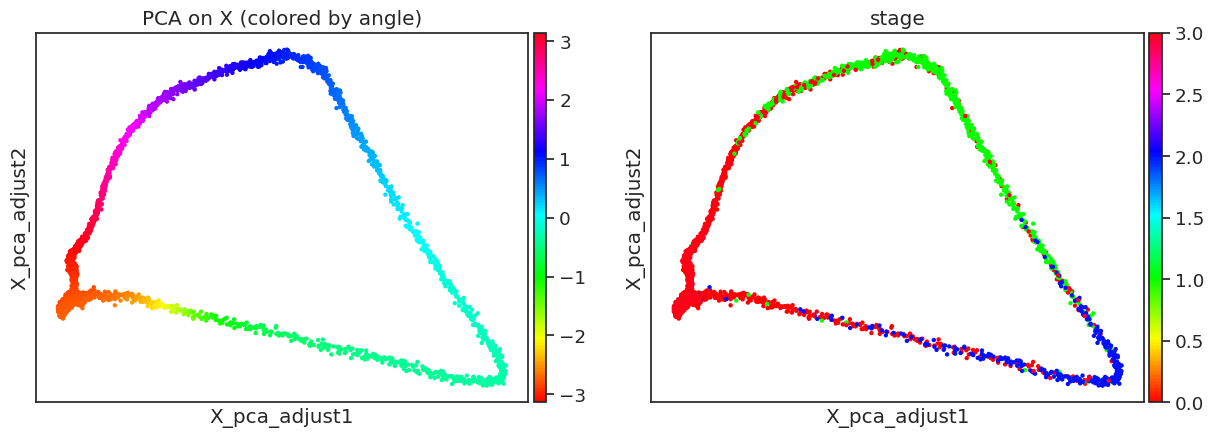

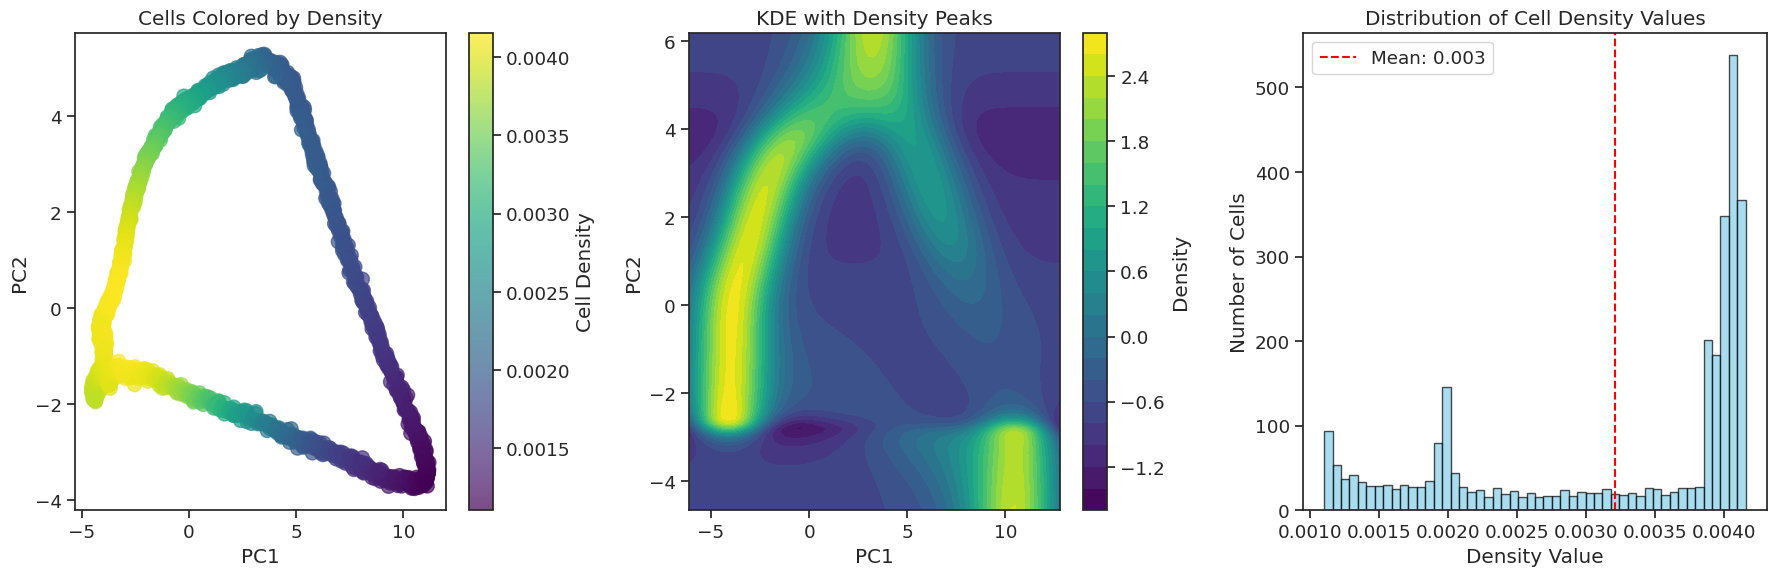

Computed density values for 3015 cells
Density range: 0.0011 - 0.0042
Mean density: 0.0032
Standard deviation: 0.0011

Found 0 density peaks
Top 5 density peaks (x, y, density):
Figure saved at: ./FigurePlot/neuron_Quiescent/hNSC-U5_attractor_with_three_reference_wo_mESC.png


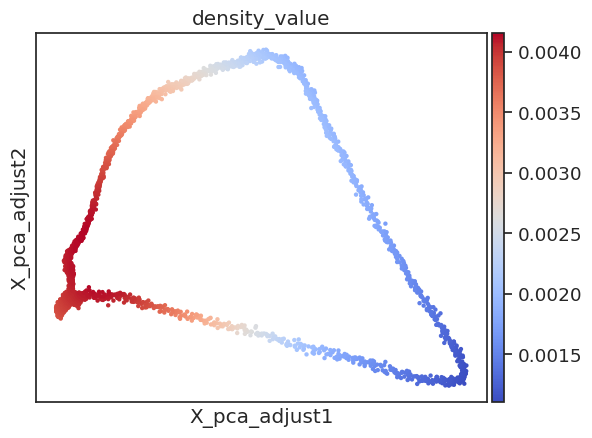

0.173


In [9]:
import os
import sys
import scanpy as sc

# ==============================
# Add HarmoCycle module path
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import *
set_seed(79710)

import os
import pandas as pd
import scanpy as sc
import numpy as np
from functools import reduce
from scipy import stats

adata2 = sc.read_h5ad('./Dataset/hNSC-U5.h5ad')
adata2.var_names_make_unique()
adata_query = adata2

refer_adata2 = sc.read_h5ad('./Experiment/Temp_Result/mESCQ_adjusted_adata.h5ad')
refer_adata3 = sc.read_h5ad('./Experiment/Temp_Result/hU2OS_adjusted_adata.h5ad')
refer_adata4 = sc.read_h5ad('./Experiment/Temp_Result/hESC_adjusted_adata.h5ad')

def gini(x):
    x = np.asarray(x, dtype=float).flatten()
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    cum = np.cumsum(x_sorted)
    g = (2.0 * np.sum((np.arange(1, n+1) * x_sorted))) / (n * cum[-1]) - (n + 1) / n
    return g

gene_set2 = get_adjust_gene(refer_adata=refer_adata2, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set3 = get_adjust_gene(refer_adata=refer_adata3, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set4 = get_adjust_gene(refer_adata=refer_adata4, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_union = reduce(np.union1d, [gene_set2, gene_set3, gene_set4])

adata_res1 = run_test(gene_set=gene_union, adata_source=adata_query.copy(), is_norm=True, is_scale=True)
adata1 = adata_query[adata_res1.obs.index, ]
adata1.obsm['X_pca_adjust'] = adata_res1.obsm['X_pca_adjust']
adata1.obs = adata_res1.obs
data = adata1.obsm['X_pca_adjust']

cell_density_values, density_peaks, density_2d, xx, yy = main(data, bandwidth=5)

adata1.obs['density_value'] = cell_density_values
adata1.uns['density_2d'] = density_2d
adata1.uns['density_grid_xx'] = xx
adata1.uns['density_grid_yy'] = yy
adata1.uns['density_peaks'] = density_peaks

# Recreate AnnData object to ensure clean structure
adata1 = sc.AnnData(
    X=adata1.X,
    obs=adata1.obs.copy(),
    var=adata1.var.copy(),
    obsm=adata1.obsm.copy(),
    uns=adata1.uns.copy()
)

# Add density values to observation metadata
adata1.obs['density_value'] = cell_density_values

# Plot PCA-adjusted embedding with red–blue colormap
sc.pl.embedding(
    adata1,
    basis='X_pca_adjust',
    color=['density_value'],
    cmap='coolwarm',   # red–blue gradient
    show=False
)

# Define save path
save_path = "./FigurePlot/neuron_Quiescent/hNSC-U5_attractor_with_three_reference_wo_mESC.png"

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure as PNG with transparent background
plt.savefig(save_path, format='png', transparent=True)

print(f"Figure saved at: {save_path}")

# Show figure (optional, useful in interactive environments)
plt.show()

# Calculate and print Gini coefficient of density values
gini_value = np.round(gini(cell_density_values), 3)
print(gini_value)

# Gini index (hNSC-U5-with-three-reference w.o. hESC)

Current working directory: /root/Cycle/Github


Epoch 1/2000, Loss: 1.1131
Epoch 50/2000, Loss: 1.0115
Epoch 100/2000, Loss: 1.0010
Epoch 150/2000, Loss: 0.9949
Epoch 200/2000, Loss: 0.9880
Epoch 250/2000, Loss: 0.9821
Epoch 300/2000, Loss: 0.9779
Epoch 350/2000, Loss: 0.9737
Epoch 400/2000, Loss: 0.9689
Epoch 450/2000, Loss: 0.9662
Epoch 500/2000, Loss: 0.9630
Epoch 550/2000, Loss: 0.9609
Epoch 600/2000, Loss: 0.9577
Epoch 650/2000, Loss: 0.9542
Epoch 700/2000, Loss: 0.9531
Epoch 750/2000, Loss: 0.9525
Epoch 800/2000, Loss: 0.9514
Epoch 850/2000, Loss: 0.9470
Epoch 900/2000, Loss: 0.9429
Epoch 950/2000, Loss: 0.9440
Epoch 1000/2000, Loss: 0.9391
Epoch 1050/2000, Loss: 0.9386
Epoch 1100/2000, Loss: 0.9425
Epoch 1150/2000, Loss: 0.9417
Epoch 1200/2000, Loss: 0.9343
Epoch 1250/2000, Loss: 0.9321
Epoch 1300/2000, Loss: 0.9343
Epoch 1350/2000, Loss: 0.9292
Epoch 1400/2000, Loss: 0.9262
Epoch 1450/2000, Loss: 0.9237
Epoch 1500/2000, Loss: 0.9258
Epoch 1550/2000, Loss: 0.9335
Epoch 1600/2000, Loss: 0.9277
Epoch 1650/2000, Loss: 0.9246
Epo

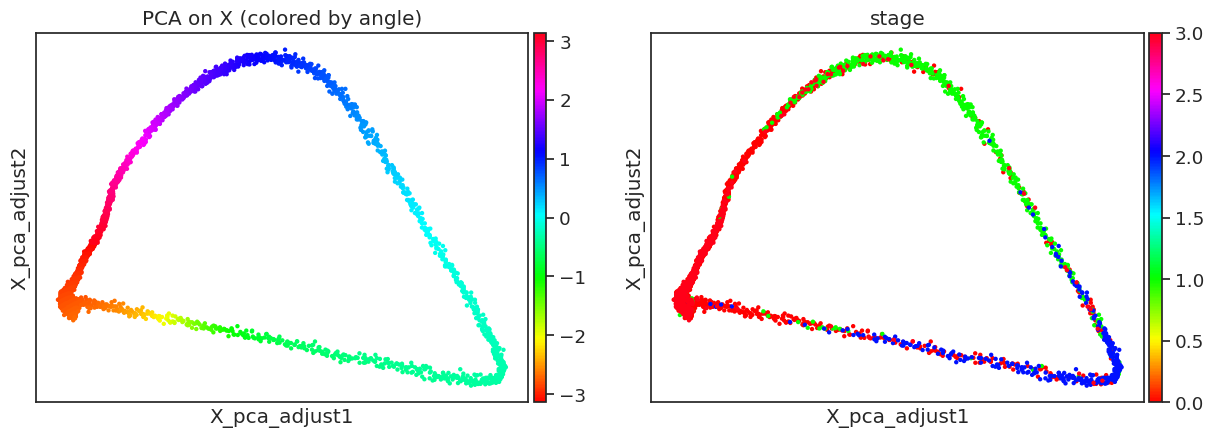

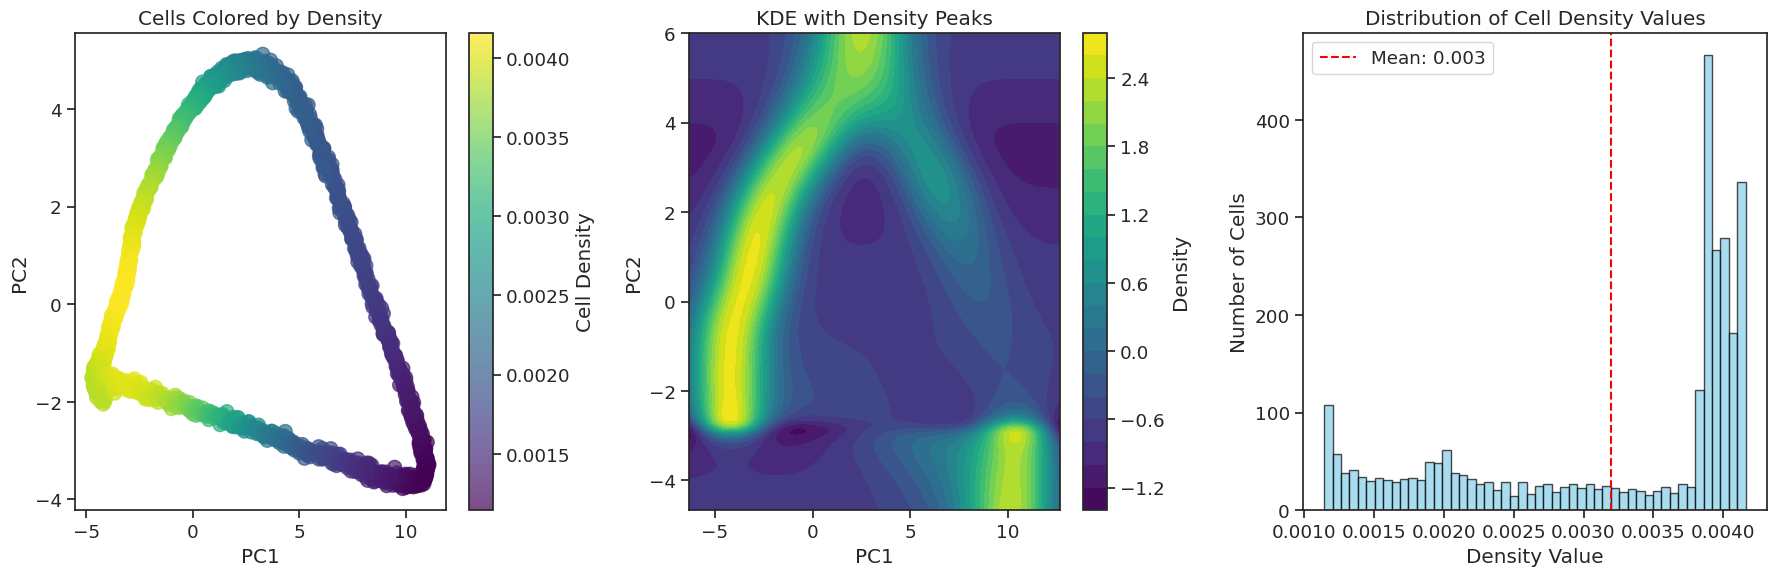

Computed density values for 3015 cells
Density range: 0.0011 - 0.0042
Mean density: 0.0032
Standard deviation: 0.0010

Found 0 density peaks
Top 5 density peaks (x, y, density):
Figure saved at: ./FigurePlot/neuron_Quiescent/hNSC-U5_attractor_with_three_reference_wo_hESC.png


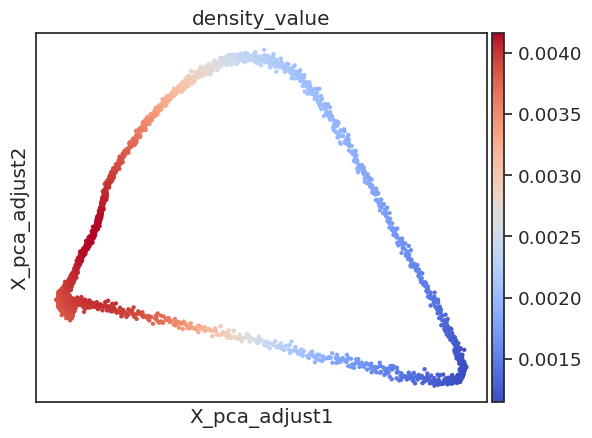

0.17


In [10]:
import os
import sys
import scanpy as sc

# ==============================
# Add HarmoCycle module path
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import *
set_seed(79710)

import os
import pandas as pd
import scanpy as sc
import numpy as np
from functools import reduce
from scipy import stats

adata2 = sc.read_h5ad('./Dataset/hNSC-U5.h5ad')
adata2.var_names_make_unique()
adata_query = adata2

refer_adata2 = sc.read_h5ad('./Experiment/Temp_Result/mESCQ_adjusted_adata.h5ad')
refer_adata3 = sc.read_h5ad('./Experiment/Temp_Result/hU2OS_adjusted_adata.h5ad')
refer_adata4 = sc.read_h5ad('./Experiment/Temp_Result/mESC_adjusted_adata.h5ad')

def gini(x):
    x = np.asarray(x, dtype=float).flatten()
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    cum = np.cumsum(x_sorted)
    g = (2.0 * np.sum((np.arange(1, n+1) * x_sorted))) / (n * cum[-1]) - (n + 1) / n
    return g

gene_set2 = get_adjust_gene(refer_adata=refer_adata2, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set3 = get_adjust_gene(refer_adata=refer_adata3, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set4 = get_adjust_gene(refer_adata=refer_adata4, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_union = reduce(np.union1d, [gene_set2, gene_set3, gene_set4])

adata_res1 = run_test(gene_set=gene_union, adata_source=adata_query.copy(), is_norm=True, is_scale=True)
adata1 = adata_query[adata_res1.obs.index, ]
adata1.obsm['X_pca_adjust'] = adata_res1.obsm['X_pca_adjust']
adata1.obs = adata_res1.obs
data = adata1.obsm['X_pca_adjust']

cell_density_values, density_peaks, density_2d, xx, yy = main(data, bandwidth=5)

adata1.obs['density_value'] = cell_density_values
adata1.uns['density_2d'] = density_2d
adata1.uns['density_grid_xx'] = xx
adata1.uns['density_grid_yy'] = yy
adata1.uns['density_peaks'] = density_peaks


# Recreate AnnData object to ensure clean structure
adata1 = sc.AnnData(
    X=adata1.X,
    obs=adata1.obs.copy(),
    var=adata1.var.copy(),
    obsm=adata1.obsm.copy(),
    uns=adata1.uns.copy()
)

# Add density values to observation metadata
adata1.obs['density_value'] = cell_density_values

# Plot PCA-adjusted embedding with red–blue colormap
sc.pl.embedding(
    adata1,
    basis='X_pca_adjust',
    color=['density_value'],
    cmap='coolwarm',   # red–blue gradient
    show=False
)

# Define save path
save_path = "./FigurePlot/neuron_Quiescent/hNSC-U5_attractor_with_three_reference_wo_hESC.png"

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure as PNG with transparent background
plt.savefig(save_path, format='png', transparent=True)

print(f"Figure saved at: {save_path}")

# Show figure (optional, useful in interactive environments)
plt.show()

# Calculate and print Gini coefficient of density values
gini_value = np.round(gini(cell_density_values), 3)
print(gini_value)

# Gini index (hNSC-PCW8-with-four-reference)

Current working directory: /root/Cycle/Github


Epoch 1/2000, Loss: 1.1504
Epoch 50/2000, Loss: 1.0162
Epoch 100/2000, Loss: 1.0102
Epoch 150/2000, Loss: 1.0020
Epoch 200/2000, Loss: 0.9960
Epoch 250/2000, Loss: 0.9880
Epoch 300/2000, Loss: 0.9856
Epoch 350/2000, Loss: 0.9820
Epoch 400/2000, Loss: 0.9827
Epoch 450/2000, Loss: 0.9765
Epoch 500/2000, Loss: 0.9748
Epoch 550/2000, Loss: 0.9717
Epoch 600/2000, Loss: 0.9668
Epoch 650/2000, Loss: 0.9667
Epoch 700/2000, Loss: 0.9623
Epoch 750/2000, Loss: 0.9589
Epoch 800/2000, Loss: 0.9592
Epoch 850/2000, Loss: 0.9575
Epoch 900/2000, Loss: 0.9508
Epoch 950/2000, Loss: 0.9513
Epoch 1000/2000, Loss: 0.9492
Epoch 1050/2000, Loss: 0.9473
Epoch 1100/2000, Loss: 0.9506
Epoch 1150/2000, Loss: 0.9459
Epoch 1200/2000, Loss: 0.9464
Epoch 1250/2000, Loss: 0.9512
Epoch 1300/2000, Loss: 0.9441
Epoch 1350/2000, Loss: 0.9365
Epoch 1400/2000, Loss: 0.9373
Epoch 1450/2000, Loss: 0.9347
Epoch 1500/2000, Loss: 0.9416
Epoch 1550/2000, Loss: 0.9395
Epoch 1600/2000, Loss: 0.9392
Epoch 1650/2000, Loss: 0.9435
Epo

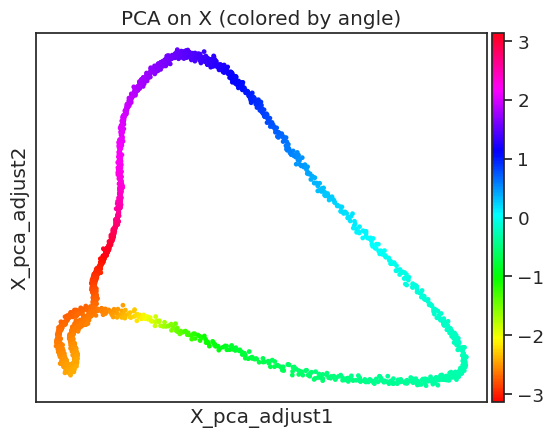

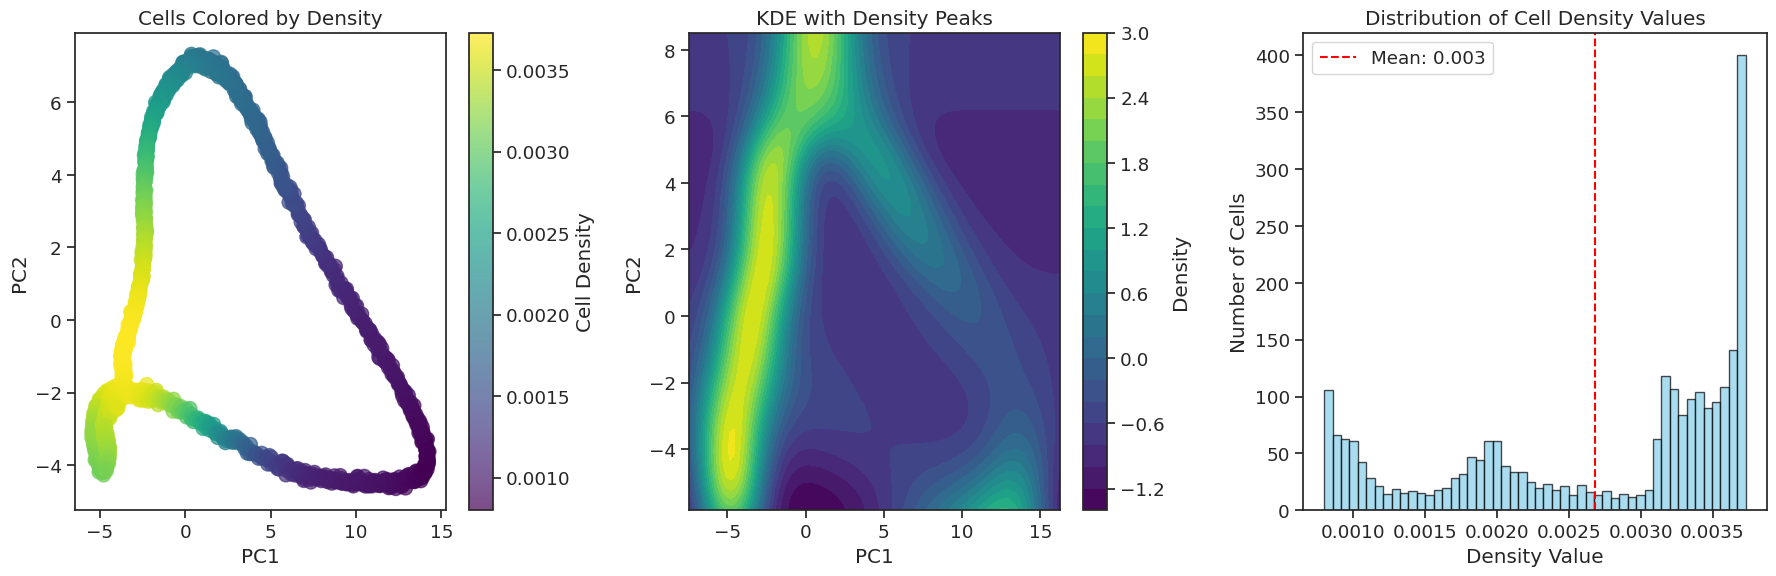

Computed density values for 2562 cells
Density range: 0.0008 - 0.0037
Mean density: 0.0027
Standard deviation: 0.0010

Found 0 density peaks
Top 5 density peaks (x, y, density):
Figure saved at: ./FigurePlot/neuron_Quiescent/hNSC-PCW8_attractor_with_four_reference.png


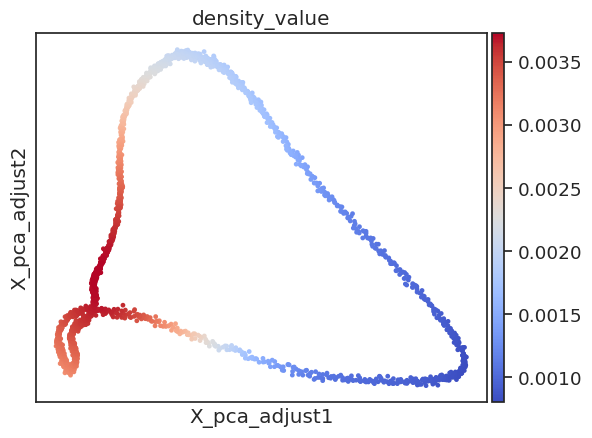

0.206


In [11]:
import os
import sys
import scanpy as sc

# ==============================
# Add HarmoCycle module path
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import *
set_seed(79710)

import os
import pandas as pd
import scanpy as sc
import numpy as np
from functools import reduce
from scipy import stats

adata2 = sc.read_h5ad('./Dataset/hNSC-PCW8.h5ad')
adata2.var_names_make_unique()
adata_query = adata2

refer_adata1 = sc.read_h5ad('./Experiment/Temp_Result/mESCQ_adjusted_adata.h5ad')
refer_adata3 = sc.read_h5ad('./Experiment/Temp_Result/hU2OS_adjusted_adata.h5ad')
refer_adata2 = sc.read_h5ad('./Experiment/Temp_Result/hESC_adjusted_adata.h5ad')
refer_adata4 = sc.read_h5ad('./Experiment/Temp_Result/mESC_adjusted_adata.h5ad')

def gini(x):
    x = np.asarray(x, dtype=float).flatten()
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    cum = np.cumsum(x_sorted)
    g = (2.0 * np.sum((np.arange(1, n+1) * x_sorted))) / (n * cum[-1]) - (n + 1) / n
    return g

gene_set1 = get_adjust_gene(refer_adata=refer_adata1, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set2 = get_adjust_gene(refer_adata=refer_adata2, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set3 = get_adjust_gene(refer_adata=refer_adata3, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set4 = get_adjust_gene(refer_adata=refer_adata4, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_union = reduce(np.union1d, [gene_set1, gene_set2, gene_set3, gene_set4])

adata_res1 = run_test(gene_set=gene_union, adata_source=adata_query.copy(), is_norm=False, is_scale=True)
adata1 = adata_query[adata_res1.obs.index, ]
adata1.obsm['X_pca_adjust'] = adata_res1.obsm['X_pca_adjust']
adata1.obs = adata_res1.obs
data = adata1.obsm['X_pca_adjust']

cell_density_values, density_peaks, density_2d, xx, yy = main(data, bandwidth=5)

adata1.obs['density_value'] = cell_density_values
adata1.uns['density_2d'] = density_2d
adata1.uns['density_grid_xx'] = xx
adata1.uns['density_grid_yy'] = yy
adata1.uns['density_peaks'] = density_peaks


# Recreate AnnData object to ensure clean structure
adata1 = sc.AnnData(
    X=adata1.X,
    obs=adata1.obs.copy(),
    var=adata1.var.copy(),
    obsm=adata1.obsm.copy(),
    uns=adata1.uns.copy()
)

# Add density values to observation metadata
adata1.obs['density_value'] = cell_density_values

# Plot PCA-adjusted embedding with red–blue colormap
sc.pl.embedding(
    adata1,
    basis='X_pca_adjust',
    color=['density_value'],
    cmap='coolwarm',   # red–blue gradient
    show=False   
)

# Define save path
save_path = "./FigurePlot/neuron_Quiescent/hNSC-PCW8_attractor_with_four_reference.png"

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure as PNG with transparent background
plt.savefig(save_path, format='png', transparent=True)

print(f"Figure saved at: {save_path}")

# Show figure (optional, useful in interactive environments)
plt.show()

# Calculate and print Gini coefficient of density values
gini_value = np.round(gini(cell_density_values), 3)
print(gini_value)

# Gini index (hNSC-PCW8-with-three-reference w.o. mESC)

Current working directory: /root/Cycle/Github


Epoch 1/2000, Loss: 1.1523
Epoch 50/2000, Loss: 0.9976
Epoch 100/2000, Loss: 0.9852
Epoch 150/2000, Loss: 0.9811
Epoch 200/2000, Loss: 0.9722
Epoch 250/2000, Loss: 0.9674
Epoch 300/2000, Loss: 0.9618
Epoch 350/2000, Loss: 0.9596
Epoch 400/2000, Loss: 0.9546
Epoch 450/2000, Loss: 0.9543
Epoch 500/2000, Loss: 0.9511
Epoch 550/2000, Loss: 0.9457
Epoch 600/2000, Loss: 0.9463
Epoch 650/2000, Loss: 0.9431
Epoch 700/2000, Loss: 0.9418
Epoch 750/2000, Loss: 0.9421
Epoch 800/2000, Loss: 0.9348
Epoch 850/2000, Loss: 0.9340
Epoch 900/2000, Loss: 0.9274
Epoch 950/2000, Loss: 0.9254
Epoch 1000/2000, Loss: 0.9252
Epoch 1050/2000, Loss: 0.9311
Epoch 1100/2000, Loss: 0.9192
Epoch 1150/2000, Loss: 0.9188
Epoch 1200/2000, Loss: 0.9271
Epoch 1250/2000, Loss: 0.9208
Epoch 1300/2000, Loss: 0.9124
Epoch 1350/2000, Loss: 0.9152
Epoch 1400/2000, Loss: 0.9121
Epoch 1450/2000, Loss: 0.9108
Epoch 1500/2000, Loss: 0.9121
Epoch 1550/2000, Loss: 0.9163
Epoch 1600/2000, Loss: 0.9033
Epoch 1650/2000, Loss: 0.9070
Epo

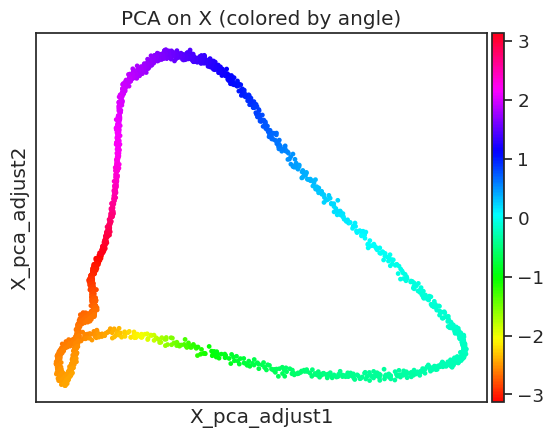

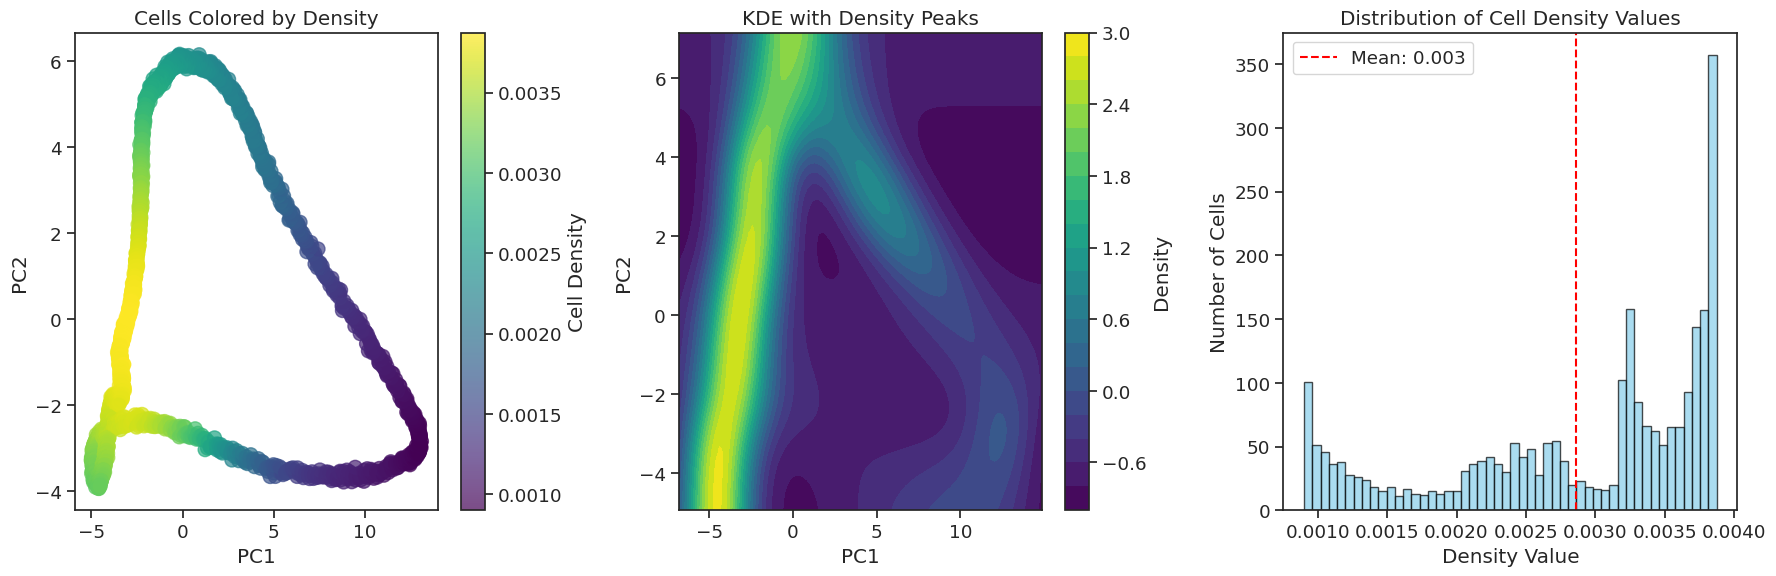

Computed density values for 2562 cells
Density range: 0.0009 - 0.0039
Mean density: 0.0029
Standard deviation: 0.0009

Found 0 density peaks
Top 5 density peaks (x, y, density):
Figure saved at: ./FigurePlot/neuron_Quiescent/hNSC-PCW8_attractor_with_three_reference_wo_mESC.png


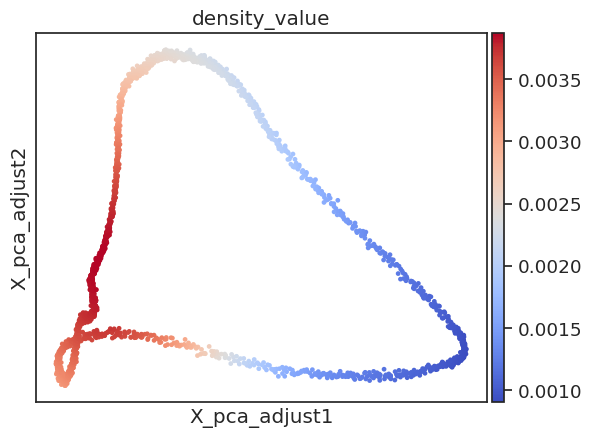

0.182


In [12]:
import os
import sys
import scanpy as sc

# ==============================
# Add HarmoCycle module path
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import *
set_seed(79710)

import os
import pandas as pd
import scanpy as sc
import numpy as np
from functools import reduce
from scipy import stats

adata2 = sc.read_h5ad('./Dataset/hNSC-PCW8.h5ad')
adata2.var_names_make_unique()
adata_query = adata2

refer_adata1 = sc.read_h5ad('./Experiment/Temp_Result/mESCQ_adjusted_adata.h5ad')
refer_adata3 = sc.read_h5ad('./Experiment/Temp_Result/hU2OS_adjusted_adata.h5ad')
refer_adata2 = sc.read_h5ad('./Experiment/Temp_Result/hESC_adjusted_adata.h5ad')

def gini(x):
    x = np.asarray(x, dtype=float).flatten()
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    cum = np.cumsum(x_sorted)
    g = (2.0 * np.sum((np.arange(1, n+1) * x_sorted))) / (n * cum[-1]) - (n + 1) / n
    return g

gene_set1 = get_adjust_gene(refer_adata=refer_adata1, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set2 = get_adjust_gene(refer_adata=refer_adata2, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set3 = get_adjust_gene(refer_adata=refer_adata3, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_union = reduce(np.union1d, [gene_set1, gene_set2, gene_set3])

adata_res1 = run_test(gene_set=gene_union, adata_source=adata_query.copy(), is_norm=False, is_scale=True)
adata1 = adata_query[adata_res1.obs.index, ]
adata1.obsm['X_pca_adjust'] = adata_res1.obsm['X_pca_adjust']
adata1.obs = adata_res1.obs
data = adata1.obsm['X_pca_adjust']

cell_density_values, density_peaks, density_2d, xx, yy = main(data, bandwidth=5)

adata1.obs['density_value'] = cell_density_values
adata1.uns['density_2d'] = density_2d
adata1.uns['density_grid_xx'] = xx
adata1.uns['density_grid_yy'] = yy
adata1.uns['density_peaks'] = density_peaks

# Recreate AnnData object to ensure clean structure
adata1 = sc.AnnData(
    X=adata1.X,
    obs=adata1.obs.copy(),
    var=adata1.var.copy(),
    obsm=adata1.obsm.copy(),
    uns=adata1.uns.copy()
)

# Add density values to observation metadata
adata1.obs['density_value'] = cell_density_values

# Plot PCA-adjusted embedding with red–blue colormap
sc.pl.embedding(
    adata1,
    basis='X_pca_adjust',
    color=['density_value'],
    cmap='coolwarm',   # red–blue gradient
    show=False   
)

# Define save path
save_path = "./FigurePlot/neuron_Quiescent/hNSC-PCW8_attractor_with_three_reference_wo_mESC.png"

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure as PNG with transparent background
plt.savefig(save_path, format='png', transparent=True)

print(f"Figure saved at: {save_path}")

# Show figure (optional, useful in interactive environments)
plt.show()

# Calculate and print Gini coefficient of density values
gini_value = np.round(gini(cell_density_values), 3)
print(gini_value)

# Gini index (hNSC-PCW8-with-three-reference w.o. hESC)

Current working directory: /root/Cycle/Github
Epoch 1/2000, Loss: 1.1539
Epoch 50/2000, Loss: 0.9955
Epoch 100/2000, Loss: 0.9869
Epoch 150/2000, Loss: 0.9793
Epoch 200/2000, Loss: 0.9742
Epoch 250/2000, Loss: 0.9702
Epoch 300/2000, Loss: 0.9648
Epoch 350/2000, Loss: 0.9625
Epoch 400/2000, Loss: 0.9550
Epoch 450/2000, Loss: 0.9532
Epoch 500/2000, Loss: 0.9482
Epoch 550/2000, Loss: 0.9457
Epoch 600/2000, Loss: 0.9453
Epoch 650/2000, Loss: 0.9419
Epoch 700/2000, Loss: 0.9395
Epoch 750/2000, Loss: 0.9417
Epoch 800/2000, Loss: 0.9386
Epoch 850/2000, Loss: 0.9366
Epoch 900/2000, Loss: 0.9296
Epoch 950/2000, Loss: 0.9345
Epoch 1000/2000, Loss: 0.9284
Epoch 1050/2000, Loss: 0.9270
Epoch 1100/2000, Loss: 0.9224
Epoch 1150/2000, Loss: 0.9166
Epoch 1200/2000, Loss: 0.9163
Epoch 1250/2000, Loss: 0.9151
Epoch 1300/2000, Loss: 0.9163
Epoch 1350/2000, Loss: 0.9138
Epoch 1400/2000, Loss: 0.9138
Epoch 1450/2000, Loss: 0.9147
Epoch 1500/2000, Loss: 0.9071
Epoch 1550/2000, Loss: 0.9057
Epoch 1600/2000, 

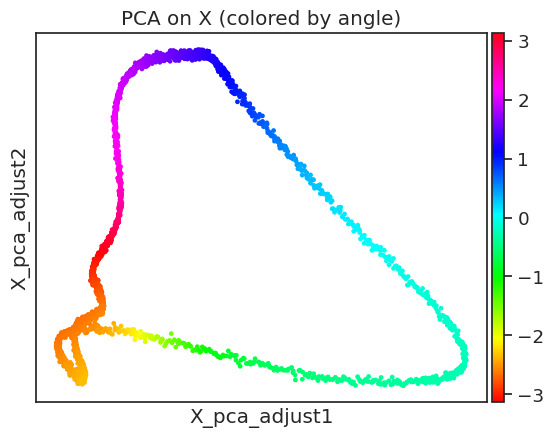

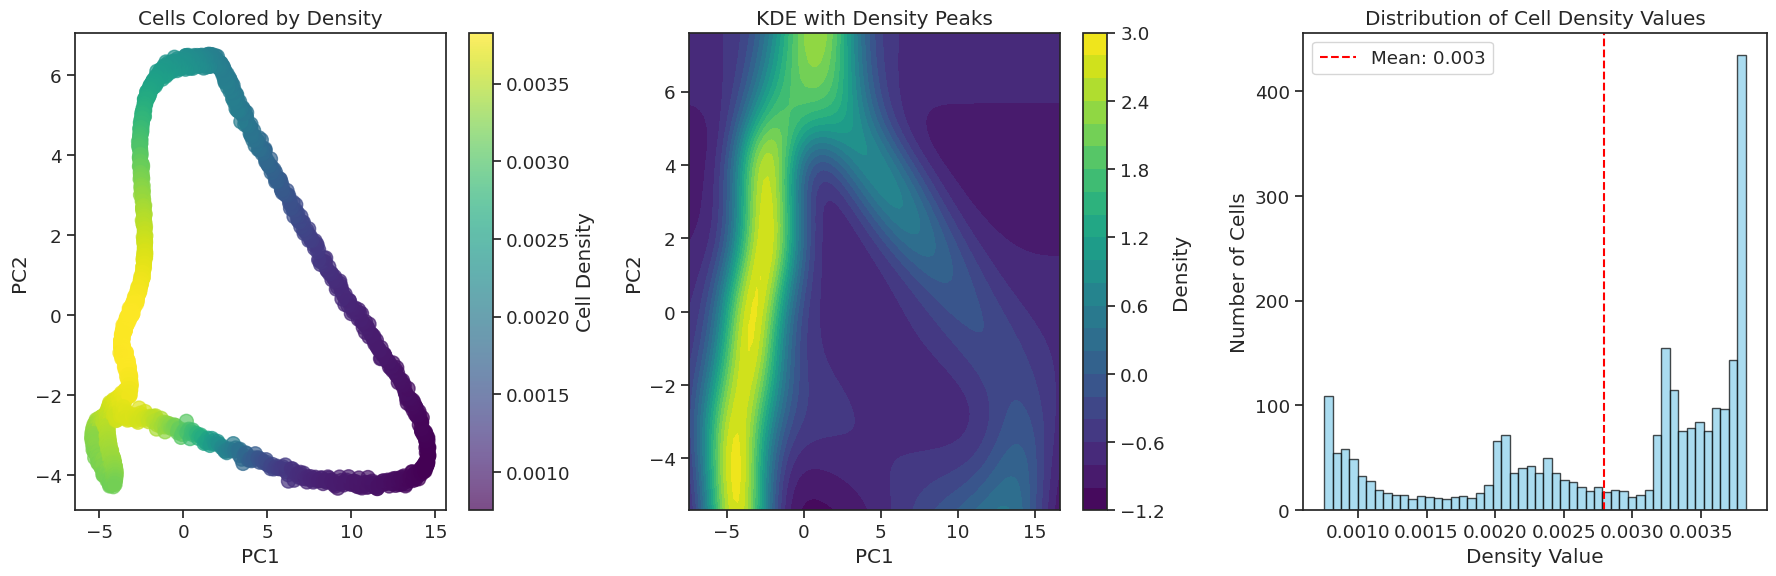

Computed density values for 2562 cells
Density range: 0.0008 - 0.0038
Mean density: 0.0028
Standard deviation: 0.0010

Found 0 density peaks
Top 5 density peaks (x, y, density):
Figure saved at: ./FigurePlot/neuron_Quiescent/hNSC-PCW8_attractor_with_three_reference_wo_hESC.png


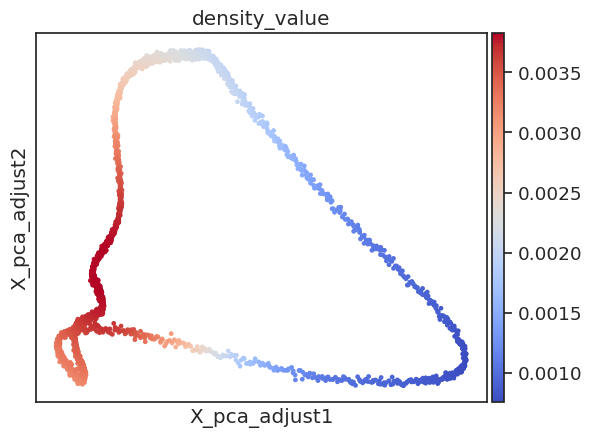

0.198


In [13]:
import os
import sys
import scanpy as sc

# ==============================
# Add HarmoCycle module path
# ==============================
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())
sys.path.append("./HarmoCycle/")

# Import custom functions
from HarmoCycle import *
from Utils import *
set_seed(79710)

import os
import pandas as pd
import scanpy as sc
import numpy as np
from functools import reduce
from scipy import stats

adata2 = sc.read_h5ad('./Dataset/hNSC-PCW8.h5ad')
adata2.var_names_make_unique()
adata_query = adata2

refer_adata1 = sc.read_h5ad('./Experiment/Temp_Result/mESCQ_adjusted_adata.h5ad')
refer_adata3 = sc.read_h5ad('./Experiment/Temp_Result/hU2OS_adjusted_adata.h5ad')
refer_adata2 = sc.read_h5ad('./Experiment/Temp_Result/mESC_adjusted_adata.h5ad')

def gini(x):
    x = np.asarray(x, dtype=float).flatten()
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    cum = np.cumsum(x_sorted)
    g = (2.0 * np.sum((np.arange(1, n+1) * x_sorted))) / (n * cum[-1]) - (n + 1) / n
    return g

gene_set1 = get_adjust_gene(refer_adata=refer_adata1, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set2 = get_adjust_gene(refer_adata=refer_adata2, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_set3 = get_adjust_gene(refer_adata=refer_adata3, adata_source=adata_query[:5, ].copy(), n_gene=200)
gene_union = reduce(np.union1d, [gene_set1, gene_set2, gene_set3])

adata_res1 = run_test(gene_set=gene_union, adata_source=adata_query.copy(), is_norm=False, is_scale=True)
adata1 = adata_query[adata_res1.obs.index, ]
adata1.obsm['X_pca_adjust'] = adata_res1.obsm['X_pca_adjust']
adata1.obs = adata_res1.obs
data = adata1.obsm['X_pca_adjust']

cell_density_values, density_peaks, density_2d, xx, yy = main(data, bandwidth=5)

adata1.obs['density_value'] = cell_density_values
adata1.uns['density_2d'] = density_2d
adata1.uns['density_grid_xx'] = xx
adata1.uns['density_grid_yy'] = yy
adata1.uns['density_peaks'] = density_peaks

# Recreate AnnData object to ensure clean structure
adata1 = sc.AnnData(
    X=adata1.X,
    obs=adata1.obs.copy(),
    var=adata1.var.copy(),
    obsm=adata1.obsm.copy(),
    uns=adata1.uns.copy()
)

# Add density values to observation metadata
adata1.obs['density_value'] = cell_density_values

# Plot PCA-adjusted embedding with red–blue colormap
sc.pl.embedding(
    adata1,
    basis='X_pca_adjust',
    color=['density_value'],
    cmap='coolwarm',   # red–blue gradient
    show=False
)

# Define save path
save_path = "./FigurePlot/neuron_Quiescent/hNSC-PCW8_attractor_with_three_reference_wo_hESC.png"

# Create directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save figure as PNG with transparent background
plt.savefig(save_path, format='png', transparent=True)

print(f"Figure saved at: {save_path}")

# Show figure (optional, useful in interactive environments)
plt.show()

# Calculate and print Gini coefficient of density values
gini_value = np.round(gini(cell_density_values), 3)
print(gini_value)